# Aprendizaje Automático

In [ ]:
!pip install shap
!pip install optuna
!pip install scikeras

# Importacion


In [ ]:

# Bibliotecas generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import dump

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Tensorflow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from tensorflow.keras import regularizers

# Optuna
import optuna
# Shap
import shap

# Plotly
import plotly.express as px
import plotly.graph_objects as go

from scikeras.wrappers import KerasRegressor


Exportacion de librerias para test local

In [ ]:
# !pip freeze > requirements.txt
# !pip list --format=freeze > requirements.txt

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los
últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las
columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos
variables en función del resto de las características que se consideren adecuadas.
Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de
lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport
(costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los
datos.

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modificar de acuerdo a entorno de trabajo

In [111]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
#file_path= '/content/drive/MyDrive/Colab Notebooks/tp automa/weatherAUS.csv'
file_path = '/content/drive/MyDrive/TUIA/4 C/AA/weatherAUS.csv'
#file_path= './weatherAUS.csv'#local
#file_path='/content/weatherAUS.csv'
df_completo = pd.read_csv(file_path, sep=',')



In [112]:
### Vista general de los  datos
df_completo.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

In [113]:
df_completo.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [114]:
df_completo.describe()

Unnamed: 0        MinTemp        MaxTemp       Rainfall  \
count  145412.000000  143928.000000  144159.000000  142152.000000   
mean    72728.184393      12.195873      23.223176       2.361516   
std     41990.722236       6.398018       7.118770       8.479338   
min         0.000000      -8.500000      -4.800000       0.000000   
25%     36362.750000       7.600000      17.900000       0.000000   
50%     72727.500000      12.000000      22.600000       0.000000   
75%    109093.250000      16.900000      28.200000       0.800000   
max    145458.000000      33.900000      48.100000     371.000000   

        Evaporation      Sunshine  WindGustSpeed   WindSpeed9am  \
count  82658.000000  75616.000000  135159.000000  143645.000000   
mean       5.468616      7.611241      40.036564      14.044742   
std        4.193871      3.785612      13.607212       8.915610   
min        0.000000      0.000000       6.000000       0.000000   
25%        2.600000      4.800000      31.000000       7.000000   
50%        4.800000      8.400000      39.000000      13.000000   
75%        7.400000     10.600000      48.000000      19.000000   
max      145.000000     14.500000     135.000000     130.000000   

        WindSpeed3pm    Humidity9am    Humidity3pm    Pressure9am  \
count  142351.000000  142759.000000  140907.000000  130351.000000   
mean       18.663164      68.877290      51.537432    1017.649277   
std         8.810276      19.029576      20.796720       7.107132   
min         0.000000       0.000000       0.000000     980.500000   
25%        13.000000      57.000000      37.000000    1012.900000   
50%        19.000000      70.000000      52.000000    1017.600000   
75%        24.000000      83.000000      66.000000    1022.400000   
max        87.000000     100.000000     100.000000    1041.000000   

         Pressure3pm      Cloud9am      Cloud3pm        Temp9am  \
count  130388.000000  89542.000000  86076.000000  143646.000000   
mean     1015.255184      4.447287      4.509770      16.992780   
std         7.037981      2.887161      2.720306       6.488045   
min       977.100000      0.000000      0.000000      -7.200000   
25%      1010.400000      1.000000      2.000000      12.300000   
50%      1015.200000      5.000000      5.000000      16.700000   
75%      1020.000000      7.000000      7.000000      21.600000   
max      1039.600000      9.000000      9.000000      40.200000   

             Temp3pm  RainfallTomorrow  
count  141805.000000     142153.000000  
mean       21.685249          2.361242  
std         6.936358          8.479084  
min        -5.400000          0.000000  
25%        16.600000          0.000000  
50%        21.100000          0.000000  
75%        26.400000          0.800000  
max        46.700000        371.000000

Del describe y head detectamos algunos detalle, primero la columna Unnamed: 0 que actua como un segundo indice, y que ciertas columnas numericas tienen valores faltantes.
Seguimos clasificando las variables en numericas y categoricas

In [115]:
#Columnas catergóricas
#df_completo.dtypes
v_categoricas=df_completo.select_dtypes(include=['object', 'category']).columns.to_list()
v_categoricas

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [116]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [117]:
locaciones = df_completo['Location'].unique()
locaciones

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

Solo se analizaran los datos de los siguientes lugares:
- Sydney
- SydneyAirport
- Canberra
- Melbourne
- MelbourneAirport

In [118]:
df = df_completo[df_completo['Location'].isin(['Sydney', 'SydneyAirport', 'Melbourne', 'MelbourneAirport', 'Canberra'])]
df.head()
#df['Location'].unique()


Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  \
30167       30176  2008-02-01   Sydney     19.5     22.4      15.6   
30168       30177  2008-02-02   Sydney     19.5     25.6       6.0   
30169       30178  2008-02-03   Sydney     21.6     24.5       6.6   
30170       30179  2008-02-04   Sydney     20.2     22.8      18.8   
30171       30180  2008-02-05   Sydney     19.7     25.7      77.4   

       Evaporation  Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm  \
30167          6.2       0.0         NaN            NaN  ...        84.0   
30168          3.4       2.7         NaN            NaN  ...        73.0   
30169          2.4       0.1         NaN            NaN  ...        86.0   
30170          2.2       0.0         NaN            NaN  ...        90.0   
30171          NaN       0.0         NaN            NaN  ...        74.0   

      Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
30167      1017.6       1017.4       8.0       8.0     20.7     20.9   
30168      1017.9       1016.4       7.0       7.0     22.4     24.8   
30169      1016.7       1015.6       7.0       8.0     23.5     23.0   
30170      1014.2       1011.8       8.0       8.0     21.4     20.9   
30171      1008.3       1004.8       8.0       8.0     22.5     25.5   

       RainToday  RainTomorrow  RainfallTomorrow  
30167        Yes           Yes               6.0  
30168        Yes           Yes               6.6  
30169        Yes           Yes              18.8  
30170        Yes           Yes              77.4  
30171        Yes           Yes               1.6  

[5 rows x 25 columns]

Chequeo de datos faltantes

In [119]:
# Datos faltantes por columna
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

In [120]:
#Eliminar las filas donde 'rainfall' tiene NaN
df = df.dropna(subset=['RainTomorrow', 'RainfallTomorrow', 'RainToday'])


In [122]:
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1681
Sunshine            1931
WindGustDir         1436
WindGustSpeed       1434
WindDir9am           672
WindDir3pm           288
WindSpeed9am         260
WindSpeed3pm         249
Humidity9am           86
Humidity3pm           43
Pressure9am          252
Pressure3pm          244
Cloud9am            1900
Cloud3pm            2136
Temp9am               22
Temp3pm               14
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [123]:
# Eliminar la columnas Unnamed: 0
df = df.drop(['Unnamed: 0'], axis=1)

In [124]:
var = [x for x in df.columns]
var

['Date',
 'Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow',
 'RainfallTomorrow']

# Análisis exploratorio

## Graficas variables numericas

In [125]:
for v in var:
  if v not in v_categoricas:
    fig = px.box(df, x=v,color='RainTomorrow')
    fig.show()

In [126]:
for v in var:
  if v not in v_categoricas:
    fig = px.box(df, x=v)
    fig.show()

## Graficos variables categoricas

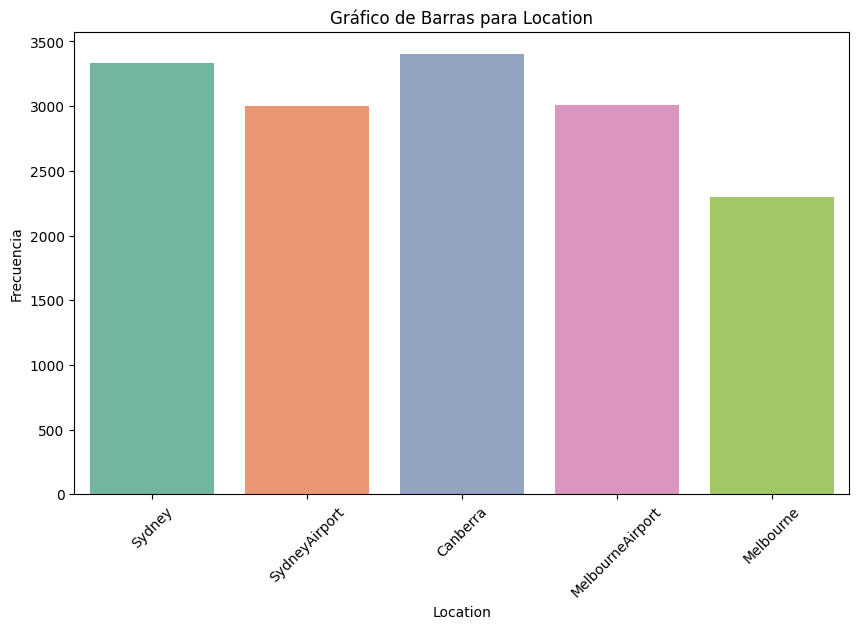

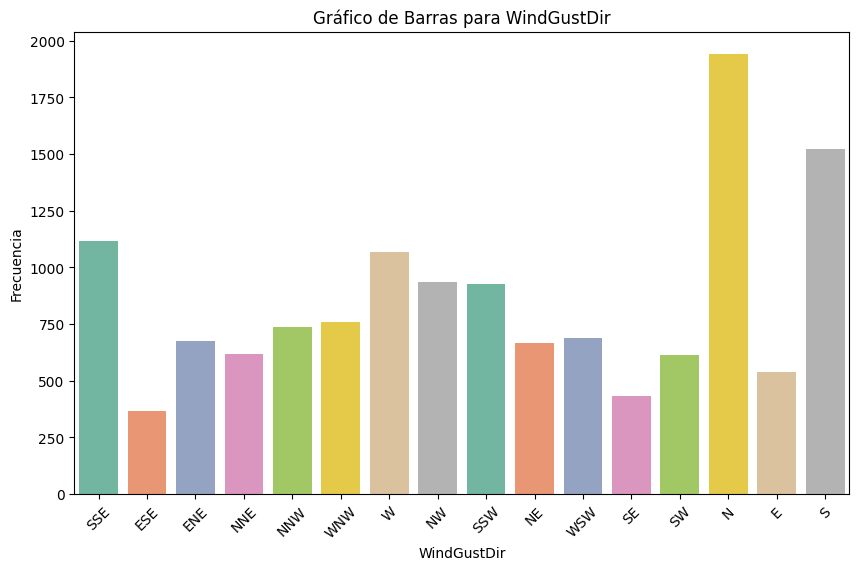

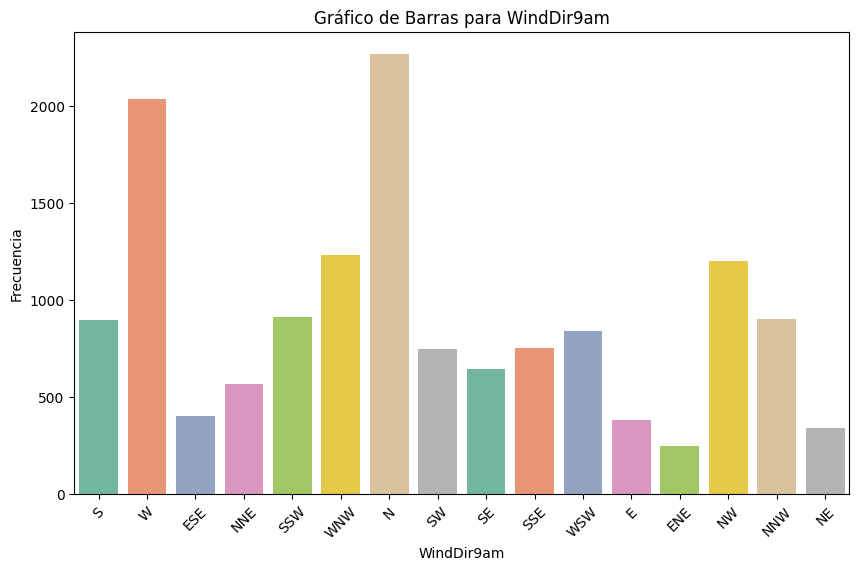

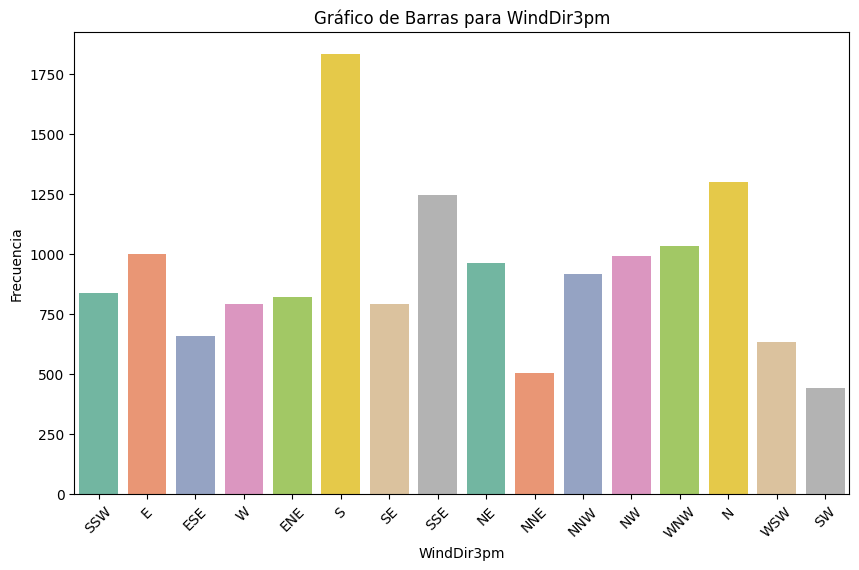

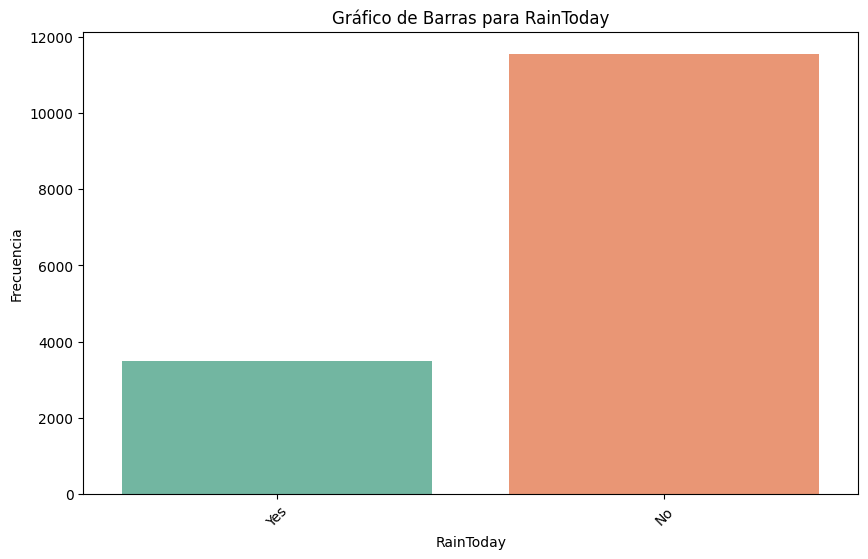

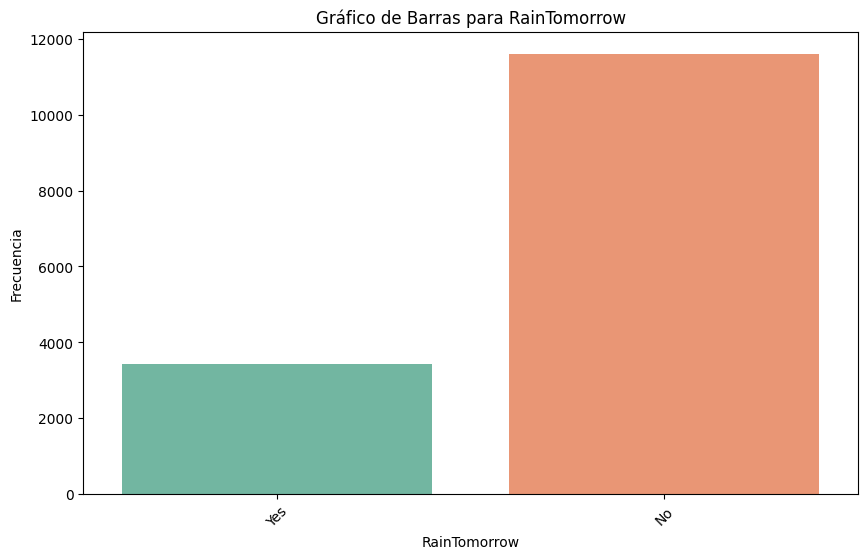

In [127]:
for columna in v_categoricas:
    if columna == 'Date': continue
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=columna, palette='Set2')
    plt.title(f'Gráfico de Barras para {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

Detectamos que el dataset esta desbalanceado en cuanto a la proporcion de registros de RainTomorrow

<ipython-input-128-b06db04eca9a>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



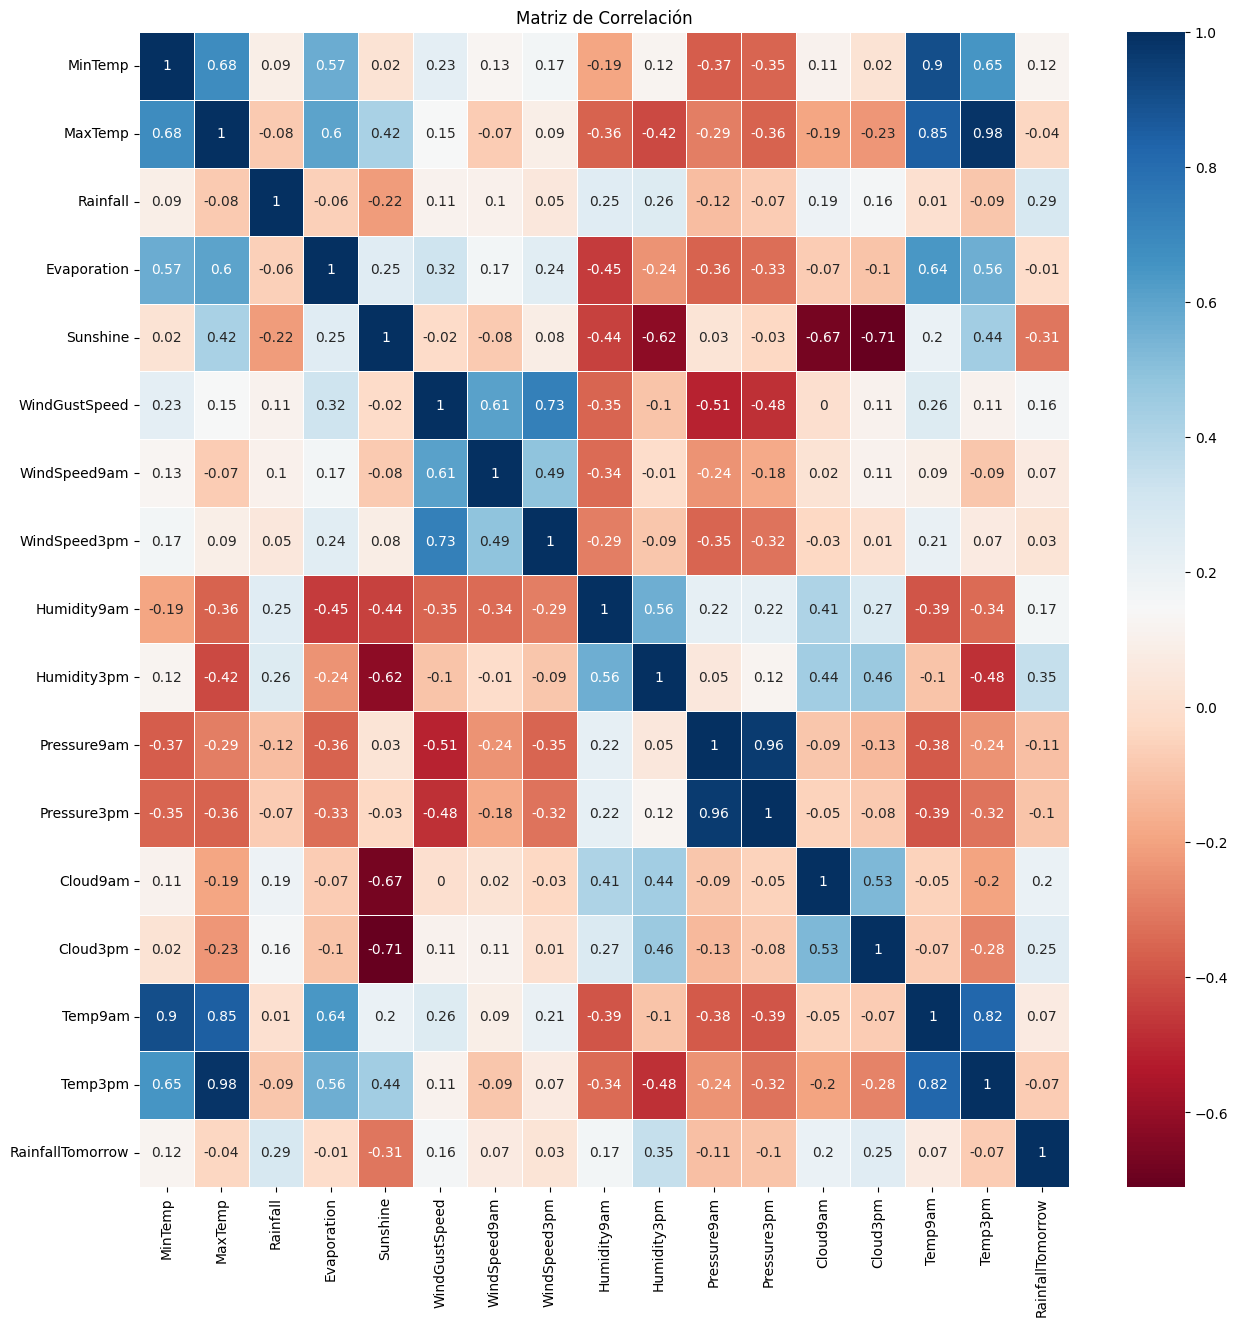

In [128]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

correlation_matrix = correlation_matrix.round(2)


plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

De la matriz de correlaicon observamos que la variable objerivo ranfalltomorrow presenta bajos valores de relacion linear con el resto de las variables, siendo el mas alto observado tan solo 0.35, y el mas bajo de -0.31

 Codificamos Rainfall tomorrow y today como binaria


In [129]:
df_codificado=df.copy()

In [130]:

#Binaria
df_codificado['RainToday'] = df_codificado['RainToday'].map({'No': 0, 'Yes': 1})
df_codificado['RainTomorrow'] = df_codificado['RainTomorrow'].map({'No': 0, 'Yes': 1})

df_codificado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 30167 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15036 non-null  object 
 1   Location          15036 non-null  object 
 2   MinTemp           15028 non-null  float64
 3   MaxTemp           15031 non-null  float64
 4   Rainfall          15036 non-null  float64
 5   Evaporation       13355 non-null  float64
 6   Sunshine          13105 non-null  float64
 7   WindGustDir       13600 non-null  object 
 8   WindGustSpeed     13602 non-null  float64
 9   WindDir9am        14364 non-null  object 
 10  WindDir3pm        14748 non-null  object 
 11  WindSpeed9am      14776 non-null  float64
 12  WindSpeed3pm      14787 non-null  float64
 13  Humidity9am       14950 non-null  float64
 14  Humidity3pm       14993 non-null  float64
 15  Pressure9am       14784 non-null  float64
 16  Pressure3pm       14792 non-null  fl

In [131]:
# Eliminamos variables categoricas que no seran tenidas en cuenta para los modelos
df_codificado_para_pipe=df_codificado.drop(['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm'], axis=1)

In [132]:
df_codificado_para_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 30167 to 70370
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           15028 non-null  float64
 1   MaxTemp           15031 non-null  float64
 2   Rainfall          15036 non-null  float64
 3   Evaporation       13355 non-null  float64
 4   Sunshine          13105 non-null  float64
 5   WindGustSpeed     13602 non-null  float64
 6   WindSpeed9am      14776 non-null  float64
 7   WindSpeed3pm      14787 non-null  float64
 8   Humidity9am       14950 non-null  float64
 9   Humidity3pm       14993 non-null  float64
 10  Pressure9am       14784 non-null  float64
 11  Pressure3pm       14792 non-null  float64
 12  Cloud9am          13136 non-null  float64
 13  Cloud3pm          12900 non-null  float64
 14  Temp9am           15014 non-null  float64
 15  Temp3pm           15022 non-null  float64
 16  RainToday         15036 non-null  in

# Pipeline de imputacion y estandarizacion

In [133]:

# Separar features (X) y target (y) para clasificacion
X = df_codificado_para_pipe.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y = df_codificado_para_pipe['RainTomorrow']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para imputación y estandarización
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación por la media
    ('scaler', StandardScaler()),  # Estandarización con la media y desviación estándar del conjunto de entrenamiento
])


# Ajustar y transformar el conjunto de entrenamiento
X_train_preprocessed  = preprocessing_pipeline.fit_transform(X_train)

# Transformar el conjunto de prueba utilizando los parámetros aprendidos del conjunto de entrenamiento
X_test_preprocessed  = preprocessing_pipeline.transform(X_test)

In [134]:
feature_names=X.columns.tolist()
feature_names

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [135]:
preprocessing_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

# Modelos de Clasificacion para RainTomorrow

In [136]:
dataClass = pd.DataFrame(columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])


In [137]:
def confusionMatrix (test,pred):
  # Obtener la matriz de confusión
  confusionIN = confusion_matrix(test, pred)

  # Crear una matriz de confusión visual con Seaborn
  sns.heatmap(confusionIN, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicciones")
  plt.ylabel("Valores Reales")
  plt.title("Matriz de Confusión")
  plt.show()

In [138]:
def curvaROC (modelo, X_test,Y_test):
  y_probsUS = modelo.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_probsUS)
  roc_auc = auc(fpr, tpr)
  # Grafico la curva ROC
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Tasa de Falsos Positivos (FPR)')
  plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
  plt.title('Curva ROC')
  plt.legend(loc="lower right")
  plt.show()

In [139]:
# Contar la cantidad de 1 (RainTomorrow=1) y 0 (RainTomorrow=0)
conteo_categorias = df_codificado_para_pipe['RainTomorrow'].value_counts()
proporcion_1 = conteo_categorias[1] / len(df)
proporcion_0 = conteo_categorias[0] / len(df)

# Verificar si el DataFrame está balanceado
if 0.4 <= proporcion_1 <= 0.6:
    print("El DataFrame está balanceado.")
else:
    print("El DataFrame no está balanceado.")


El DataFrame no está balanceado.


Planteamos un modelo ingenuo, donde pronostica un 75% de los dias como Sin lluvia aleatoriamente como base para comparar metricas. Pero se observa claramente

Modelo Ingenuo
Accuracy: 0.61
Precision: 0.199
Recall: 0.2132
F1 Score: 0.2058
ROC-AUC: 0.4733


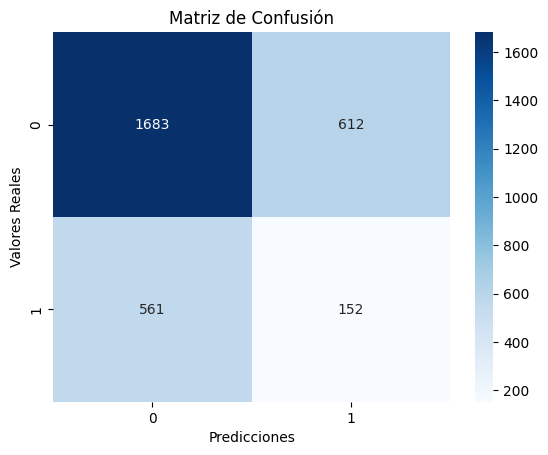

In [140]:
# Modelo ingenuo para clasificacion
# Proporción deseada de No llueve (0) y Llueve (1)
proporcion_no_llueve = .75
proporcion_llueve = 0.25


# Dividir el conjunto de datos en entrenamiento y prueba

np.random.seed(42)
predicciones_ingenuas = np.random.choice([0, 1], size=len(X_test_preprocessed), p=[proporcion_no_llueve, proporcion_llueve])


# Evaluar el rendimiento del modelo ingenuo
accuracy = accuracy_score(y_test, predicciones_ingenuas)
precision = precision_score(y_test, predicciones_ingenuas)
recall = recall_score(y_test, predicciones_ingenuas)
f1 = f1_score(y_test, predicciones_ingenuas)
roc_auc = roc_auc_score(y_test, predicciones_ingenuas)

print("Modelo Ingenuo")
print("Accuracy:", accuracy.round(4))
print("Precision:", precision.round(4))
print("Recall:", recall.round(4))
print("F1 Score:", f1.round(4))
print("ROC-AUC:", roc_auc.round(4))

confusionMatrix(y_test,predicciones_ingenuas)
dataClass = pd.concat([dataClass,pd.DataFrame([{'Modelo': "Ingenuo", 'Accuracy': accuracy,
                                  'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC-AUC': roc_auc}])], ignore_index=True)

Modelo: Desbalanceado
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2295
           1       0.80      0.39      0.52       713

    accuracy                           0.83      3008
   macro avg       0.82      0.68      0.71      3008
weighted avg       0.83      0.83      0.81      3008



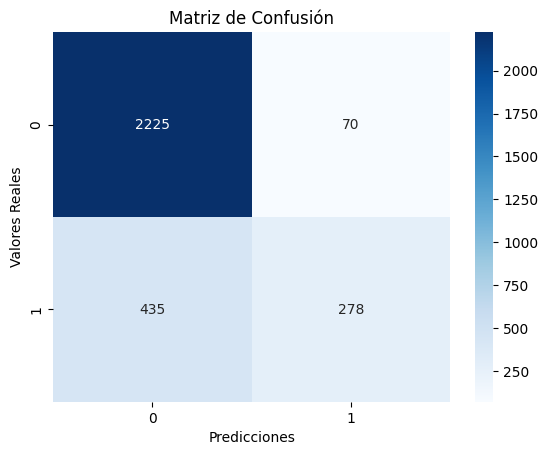

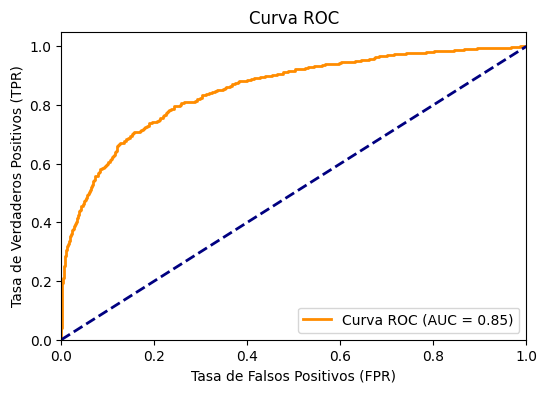

Modelo: RandomUnderSampler
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2295
           1       0.52      0.76      0.62       713

    accuracy                           0.78      3008
   macro avg       0.72      0.77      0.73      3008
weighted avg       0.82      0.78      0.79      3008



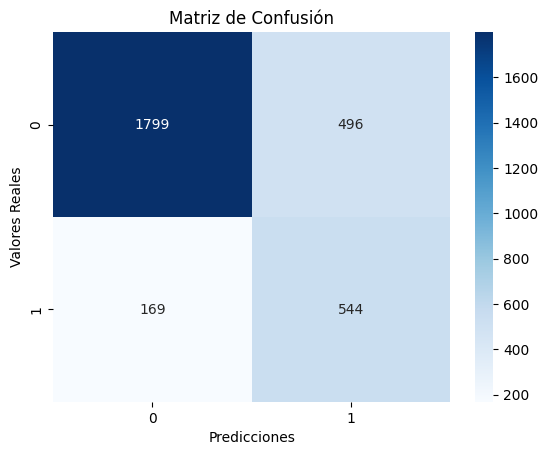

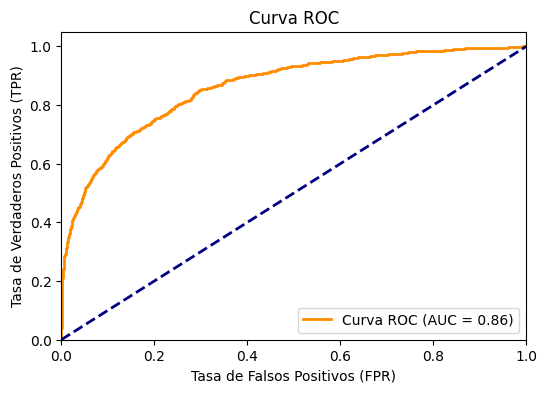

Modelo: RandomOverSampler
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2295
           1       0.52      0.77      0.62       713

    accuracy                           0.78      3008
   macro avg       0.72      0.77      0.73      3008
weighted avg       0.82      0.78      0.79      3008



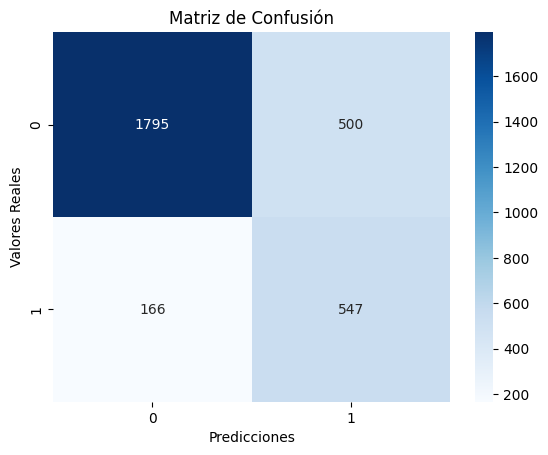

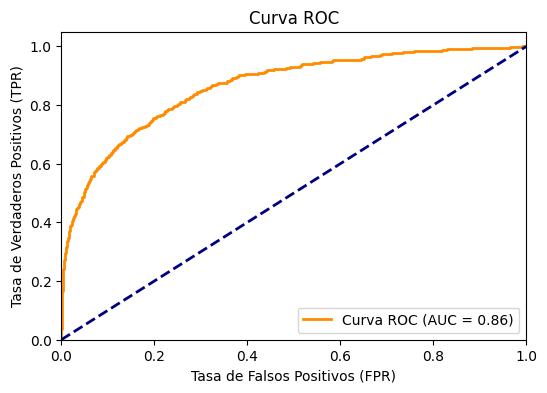

Modelo: SMOTE
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2295
           1       0.52      0.76      0.62       713

    accuracy                           0.78      3008
   macro avg       0.72      0.77      0.73      3008
weighted avg       0.82      0.78      0.79      3008



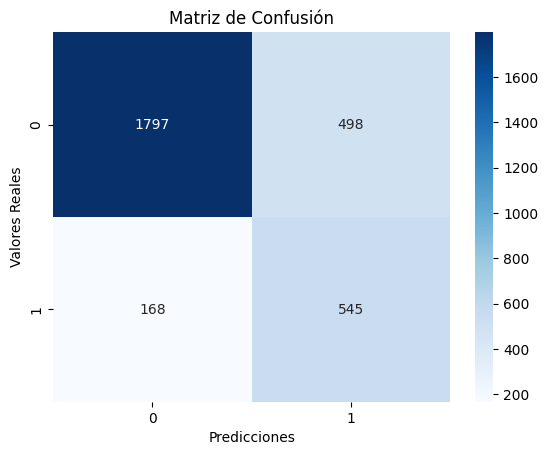

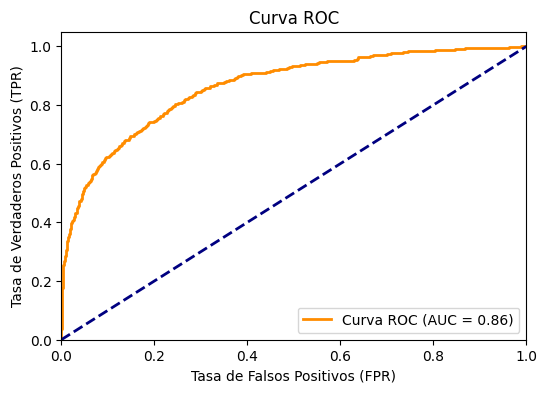


Results for Desbalanceado:
{'best_params': {'classifier__C': 0.001, 'classifier__penalty': 'l2'}, 'accuracy': 0.8321, 'precision': 0.7989, 'recall': 0.3899, 'f1': 0.524, 'roc_auc': 0.8534}

Results for RandomUnderSampler:
{'best_params': {'classifier__C': 1, 'classifier__penalty': 'l2'}, 'accuracy': 0.7789, 'precision': 0.5231, 'recall': 0.763, 'f1': 0.6207, 'roc_auc': 0.8627}

Results for RandomOverSampler:
{'best_params': {'classifier__C': 10, 'classifier__penalty': 'l2'}, 'accuracy': 0.7786, 'precision': 0.5224, 'recall': 0.7672, 'f1': 0.6216, 'roc_auc': 0.8637}

Results for SMOTE:
{'best_params': {'classifier__C': 0.1, 'classifier__penalty': 'l2'}, 'accuracy': 0.7786, 'precision': 0.5225, 'recall': 0.7644, 'f1': 0.6207, 'roc_auc': 0.8633}


In [141]:

# Crear resamplers para cada caso
resamplers = {
    'Desbalanceado': None,  # No resampling
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
}

# Crear pipelines y realizar la búsqueda de hiperparámetros con validación cruzada para cada caso
results = {}
modelos={}
for name, resampler in resamplers.items():
    # Aplicar el resampling a X_train y X_test si el resampler no es None
    if resampler is not None:
        X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_preprocessed, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_preprocessed, y_train

    # Crear el pipeline con regresión logística
    logistic_regression_pipeline = Pipeline([
        ('classifier', LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000))
    ])

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2']
    }

    # Realizar la búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(logistic_regression_pipeline, param_grid, cv=KFold(n_splits=5), scoring='precision')
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Obtener las predicciones en el conjunto de prueba
    y_pred = grid_search.predict(X_test_preprocessed)

    # Calcular métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test_preprocessed)[:, 1])
    reporte_clasificacion = classification_report(y_test, y_pred)
    print(f"Modelo: {name}")
    print("Informe de Clasificación:")
    print(reporte_clasificacion)
    # Almacenar resultados en el diccionario
    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy.round(4),
        'precision': precision.round(4),
        'recall': recall.round(4),
        'f1': f1.round(4),
        'roc_auc': roc_auc.round(4),
        #'Reporte clasificacion': reporte_clasificacion
    }
    dataClass = pd.concat([dataClass,pd.DataFrame([{'Modelo': name, 'Accuracy': accuracy,
                                  'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC-AUC': roc_auc}])], ignore_index=True)
    confusionMatrix(y_test,y_pred)
    curvaROC (grid_search, X_test_preprocessed,y_test)

    modelos[name]=grid_search.best_estimator_['classifier']



# Imprimir resultados
for name, metrics in results.items():
    print(f"\nResults for {name}:\n{metrics}")


## Comparacion modelos Regresion Logistica

In [142]:

# Especifica las métricas que deseas graficar
columnas_metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

# Reformula el DataFrame para tener una fila por métrica
data_melted = dataClass.melt(id_vars=['Modelo'], value_vars=columnas_metricas, var_name='Métrica', value_name='Valor de la Métrica')

# Redondea los valores a 3 decimales
data_melted['Valor de la Métrica'] = data_melted['Valor de la Métrica'].round(3)

# Crear un gráfico de barras agrupadas para cada modelo
fig = px.bar(data_melted, x='Modelo', y='Valor de la Métrica', color='Métrica',
             title='Gráfico de Barras para Cada Métrica por Modelo',
             labels={'Modelo': 'Modelo', 'Valor de la Métrica': 'Valor de la Métrica', 'Métrica': 'Métrica'},
             barmode='group', text='Valor de la Métrica', height=500)

fig.show()

Mediante la aplicacion de tecnicas de balanceo de datos conseguimos mejorar las metricas que consideramos mas importantes que eran las relacionadas a la disminucion del Error del Tipo 2. En ese sentido observamos que con cualquier tipo de balanceo se mejora esa metrica considerablemente a costa de Precision y Accuracy principalmente.

In [143]:
logistic_regression_pipeline

Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Explicabilidad con SHAP

### Local

In [144]:
# Elegimos el desbalanceado pero tenemos en el diccionario todos los modelos
model=modelos['Desbalanceado']

In [145]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(modelos['Desbalanceado'], X_train_preprocessed, feature_names=feature_names)

In [146]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_preprocessed)

In [147]:
shap_values.shape

(3008, 17)

In [148]:
explainer.expected_value

-1.6112938291228414

In [149]:
log_odds = model.intercept_ + np.dot(X_train_preprocessed, modelos['Desbalanceado'].coef_.T)
np.mean(log_odds)

-1.5331342151431389

In [150]:
index=0

In [151]:
model.predict_proba(X_train_preprocessed)[index]

array([0.87594377, 0.12405623])

In [152]:
model.predict(X_train_preprocessed)[index]

0

In [153]:
shap_values[index]

array([ 0.06928167,  0.01470471, -0.03522561, -0.03982293,  0.55835542,
        0.46868812,  0.0040407 , -0.00759603, -0.15079443, -0.93967146,
        0.20189757,  0.39759651,  0.0364489 ,  0.26429714,  0.15483536,
       -0.08978937, -0.06328877])

In [154]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)


In [155]:
explanation

.values =
array([ 0.06928167,  0.01470471, -0.03522561, -0.03982293,  0.55835542,
        0.46868812,  0.0040407 , -0.00759603, -0.15079443, -0.93967146,
        0.20189757,  0.39759651,  0.0364489 ,  0.26429714,  0.15483536,
       -0.08978937, -0.06328877])

.base_values =
-1.6112938291228414

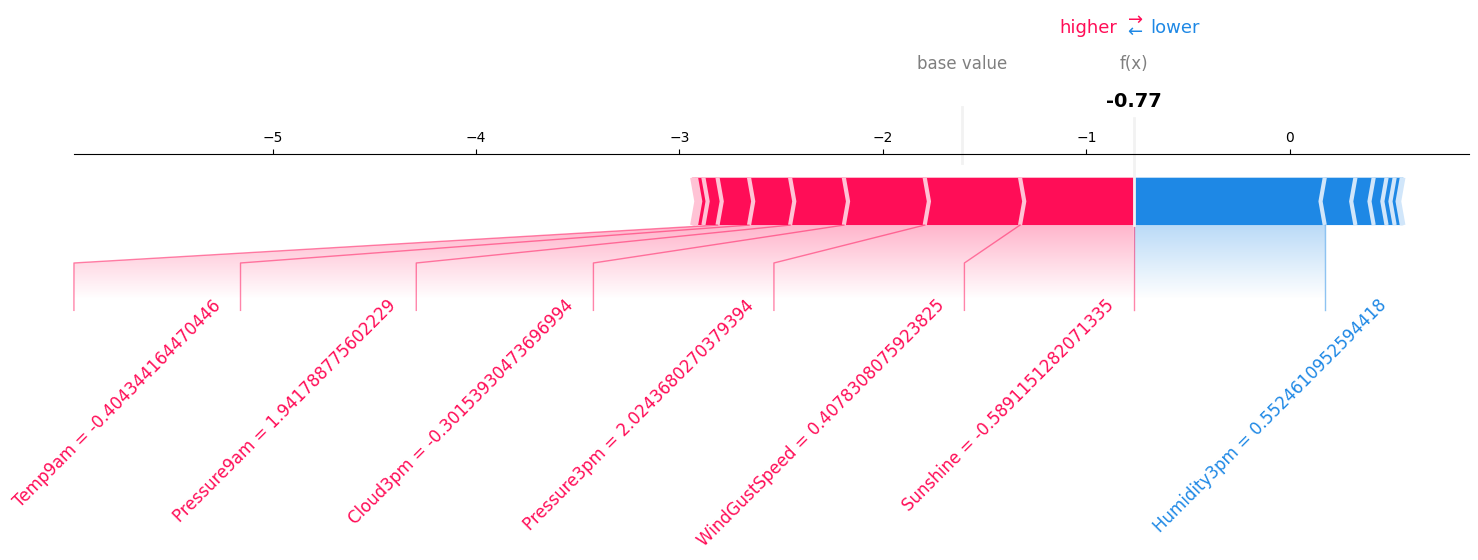

In [156]:
shap.force_plot(explainer.expected_value, explanation.values, X_train_preprocessed[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

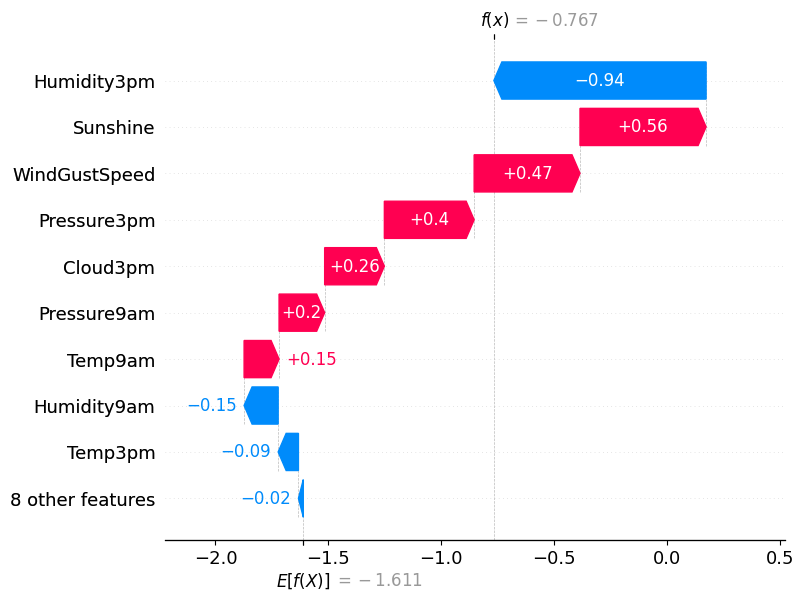

In [157]:
shap.plots.waterfall(explanation)

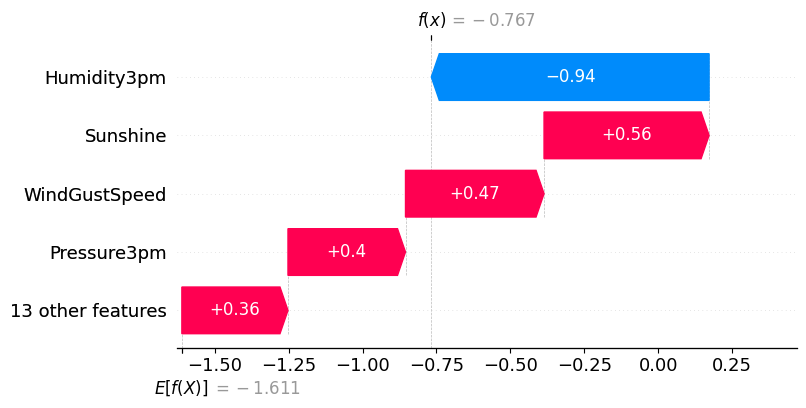

In [158]:
shap.plots.waterfall(explanation, max_display=5)

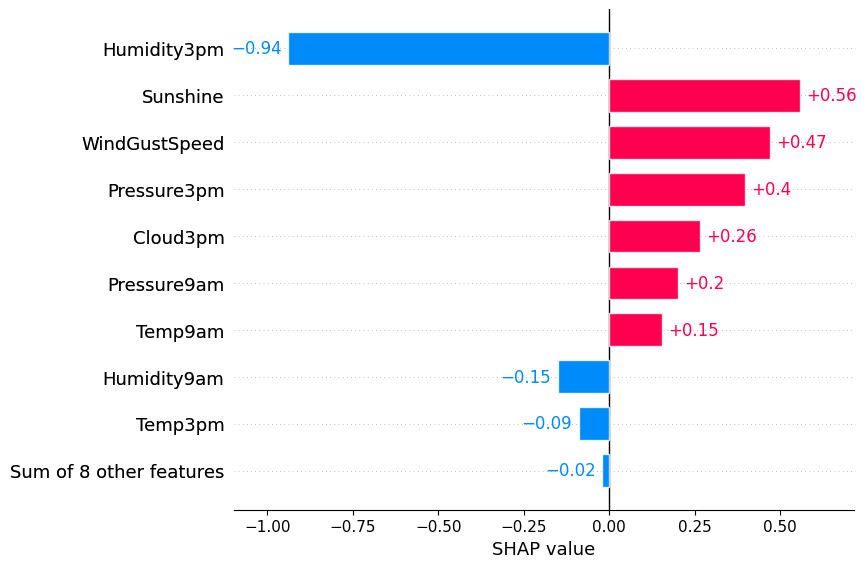

In [159]:
shap.plots.bar(explanation)

Con esta serie de graficos comprobamos el impacto de las features en la prediccion para un resultado especifico. Se observa que la Humidity3pm tiene el mayor impacto en terminos absolutos, mas del doble de la siguiente.

### Global

In [160]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_preprocessed)

In [161]:
explanation.data

array([[ 1.35469648,  2.60017283, -0.30917535, ...,  1.66932981,
         2.42052775, -0.55250625],
       [ 0.48225416,  0.45384485, -0.30917535, ...,  0.37102958,
         0.31916891, -0.55250625],
       [ 0.73885484,  0.27223248, -0.30917535, ...,  0.65954074,
         0.35333735, -0.55250625],
       ...,
       [-0.95470967, -1.36227883, -0.30917535, ..., -1.21578181,
        -1.44050556, -0.55250625],
       [ 0.44804073,  0.94915131, -0.30917535, ...,  1.07427554,
         1.20754826, -0.55250625],
       [-0.56125529,  1.27935561, -0.30917535, ...,  0.69560464,
         1.44672731, -0.55250625]])

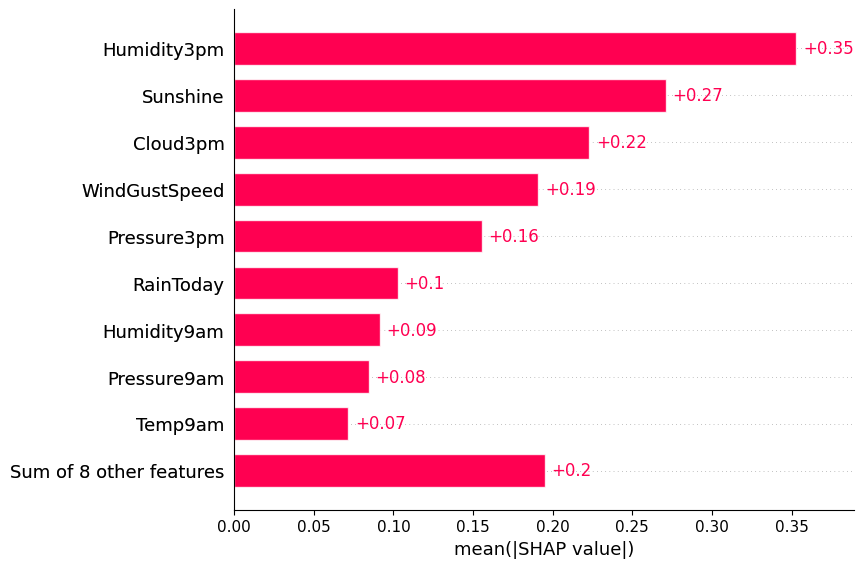

In [162]:
shap.plots.bar(explanation)

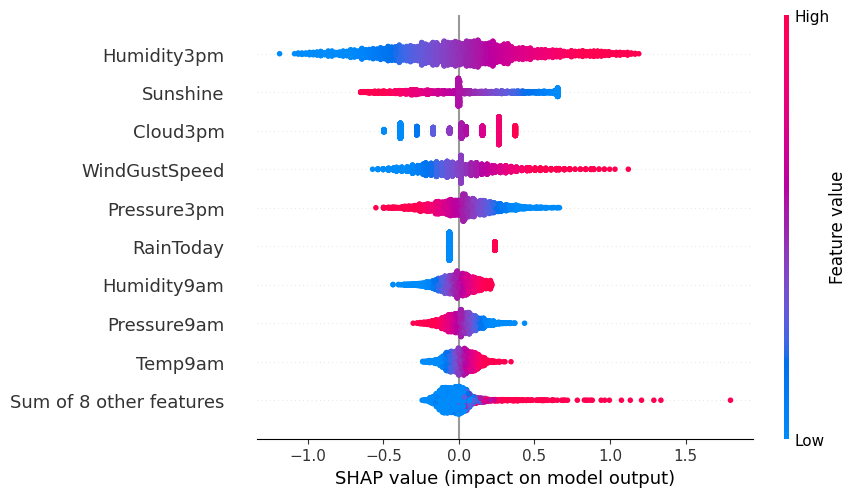

In [163]:
shap.plots.beeswarm(explanation)

En terminos globales la feature humidity3pm sigue siendo la de mayor impacto, pero no con la diferencia del caso puntual anterior. Muchas de las features tienen impactos menores a +/- 0.5 salvo en casos excepcionales

# Modelo de Redes Neuronales para Regresion Logistica

In [164]:
# Separar un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Función objetivo para la optimización de Optuna
def objective(trial):
    # Definir el modelo de Keras
    model = Sequential()

    # Número óptimo de capas ocultas (entre 1 y 3)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)

    # Tamaño de cada capa oculta (entre 8 y 128 nodos)
    hidden_layer_sizes = [trial.suggest_int(f'n_units_l{i}', 8, 64) for i in range(num_hidden_layers)]

    # Agregar capas ocultas al modelo
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_layer_sizes[i], activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))  # Salida sigmoidal para clasificación binaria

    # Optimizador y tasa de aprendizaje
    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True))

    # Compilar el modelo
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

    # Entrenamiento del modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=trial.suggest_int('epochs', 100, 1000),
        batch_size=trial.suggest_int('batch_size', 128, 2048),
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  # Puedes ajustar la verbosidad según tus necesidades
    )

    # Evaluación del modelo en el conjunto de validación
    y_pred = (model.predict(X_val) > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias
    val_recall = recall_score(y_val, y_pred)

    return 1 - val_recall  # Minimizar el complemento de recall (equivalente a maximizar recall)

# Crear un estudio de Optuna y realizar la optimización
study = optuna.create_study(direction='minimize')  # Queremos minimizar el complemento de recall
study.optimize(objective, n_trials=15)

# Imprimir los resultados
print('Best trial:')
trial = study.best_trial
print(f'Value: {1 - trial.value}')  # Imprimir recall
print('Params: ')
best_paramsRL=trial.params
for key, value in trial.params.items():

    print(f'    {key}: {value}')

# # Entrenar el modelo con la mejor configuración encontrada
# best_model = Sequential()
# for i in range(trial.params['num_hidden_layers']):
#     best_model.add(Dense(trial.params[f'n_units_l{i}'], activation='relu'))
# best_model.add(Dense(1, activation='sigmoid'))
# best_model.compile(optimizer=Adam(learning_rate=trial.params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
# best_model.fit(X_train, y_train, epochs=trial.params['epochs'], batch_size=trial.params['batch_size'])


[I 2023-12-07 20:33:26,466] A new study created in memory with name: no-name-8cf4bd88-96df-43e8-a8e0-456b5735fffe


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:33:46,312] Trial 0 finished with value: 0.14886552296624234 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 58, 'n_units_l1': 22, 'n_units_l2': 53, 'learning_rate': 0.0006963141123024882, 'epochs': 672, 'batch_size': 1821}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 1s 6ms/step


[I 2023-12-07 20:35:46,186] Trial 1 finished with value: 0.15107913669064743 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 57, 'n_units_l1': 53, 'n_units_l2': 13, 'learning_rate': 9.201850580816266e-05, 'epochs': 714, 'batch_size': 713}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:36:09,422] Trial 2 finished with value: 0.18151632540121754 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 35, 'learning_rate': 0.005979903981141943, 'epochs': 870, 'batch_size': 738}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 1s 4ms/step


[I 2023-12-07 20:36:31,639] Trial 3 finished with value: 0.22744881018262308 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 53, 'learning_rate': 9.153358100205687e-05, 'epochs': 103, 'batch_size': 765}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:38:28,760] Trial 4 finished with value: 0.16380741560597678 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 48, 'n_units_l1': 40, 'n_units_l2': 37, 'learning_rate': 4.242340593846659e-05, 'epochs': 528, 'batch_size': 442}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 1ms/step


[I 2023-12-07 20:39:53,003] Trial 5 finished with value: 0.17321527393469838 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 33, 'n_units_l1': 52, 'n_units_l2': 43, 'learning_rate': 7.306654519722701e-05, 'epochs': 787, 'batch_size': 475}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:40:12,337] Trial 6 finished with value: 0.1599335915882678 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 37, 'n_units_l1': 42, 'learning_rate': 0.0010471063368579544, 'epochs': 196, 'batch_size': 494}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:40:34,289] Trial 7 finished with value: 0.19867183176535697 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 60, 'n_units_l1': 63, 'n_units_l2': 42, 'learning_rate': 9.66528533592287e-05, 'epochs': 169, 'batch_size': 1896}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 1ms/step


[I 2023-12-07 20:40:46,293] Trial 8 finished with value: 0.21084670724958499 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 32, 'n_units_l1': 33, 'learning_rate': 0.00011658847630581697, 'epochs': 101, 'batch_size': 1001}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:41:08,171] Trial 9 finished with value: 0.17321527393469838 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 35, 'n_units_l1': 40, 'learning_rate': 0.0015064428114147815, 'epochs': 202, 'batch_size': 1364}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:41:20,487] Trial 10 finished with value: 0.18372993912562263 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 14, 'n_units_l1': 8, 'n_units_l2': 62, 'learning_rate': 0.0506946226604007, 'epochs': 495, 'batch_size': 1987}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:42:43,118] Trial 11 finished with value: 0.2208079690094079 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 64, 'n_units_l1': 19, 'n_units_l2': 8, 'learning_rate': 1.2924251187212301e-05, 'epochs': 702, 'batch_size': 1474}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:43:25,613] Trial 12 finished with value: 0.16159380188157169 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 48, 'n_units_l1': 21, 'n_units_l2': 9, 'learning_rate': 0.0003755815401635775, 'epochs': 653, 'batch_size': 1555}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 1ms/step


[I 2023-12-07 20:43:46,552] Trial 13 finished with value: 0.18206972883231876 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 55, 'n_units_l1': 26, 'learning_rate': 0.00041565665119246923, 'epochs': 417, 'batch_size': 1142}. Best is trial 0 with value: 0.14886552296624234.


117/117 [==============================] - 0s 2ms/step


[I 2023-12-07 20:49:10,876] Trial 14 finished with value: 0.16325401217487545 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 44, 'n_units_l1': 52, 'n_units_l2': 60, 'learning_rate': 1.5262851663390267e-05, 'epochs': 991, 'batch_size': 161}. Best is trial 0 with value: 0.14886552296624234.


Best trial:
Value: 0.8511344770337577
Params: 
    num_hidden_layers: 3
    n_units_l0: 58
    n_units_l1: 22
    n_units_l2: 53
    learning_rate: 0.0006963141123024882
    epochs: 672
    batch_size: 1821


In [165]:
optuna.visualization.plot_optimization_history(study, target_name="Complemento al Recall")

In [166]:
optuna.visualization.plot_param_importances(study, target_name="Complemento al Recall")

Graficas de la evolucion del ensayo de optuna y el impacto de los hiperparametros testeados en los mismos.

In [167]:
# Imprimir los resultados
print('Best trial:')
trial = study.best_trial
print(f'Value: {1 - trial.value}')  # Imprimir complemento de recall (equivalente a recall)
print('Params: ')
for key, value in best_paramsRL.items():
    print(f'    {key}: {value}')

# Obtener el modelo con la mejor configuración encontrada
best_model_class = Sequential()
for i in range(best_paramsRL['num_hidden_layers']):
    best_model_class.add(Dense(best_paramsRL[f'n_units_l{i}'], activation='relu'))
best_model_class.add(Dense(1, activation='sigmoid'))
best_model_class.compile(optimizer=Adam(learning_rate=best_paramsRL['learning_rate']), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

# Entrenar el modelo con la mejor configuración
best_model_class.fit(X_train_resampled, y_train_resampled, epochs=best_paramsRL['epochs'], batch_size=best_paramsRL['batch_size'], verbose=0)

# Calcular las predicciones en el conjunto de test
y_pred = (best_model_class.predict(X_test_preprocessed) > 0.5).astype(int)


Best trial:
Value: 0.8511344770337577
Params: 
    num_hidden_layers: 3
    n_units_l0: 58
    n_units_l1: 22
    n_units_l2: 53
    learning_rate: 0.0006963141123024882
    epochs: 672
    batch_size: 1821
94/94 [==============================] - 0s 3ms/step


In [168]:

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_preprocessed)[:, 1])
#roc_auc = roc_auc_score(y_val, best_model.predict_proba(X_val))
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy.round(4)}")
print(f"Recall: {recall.round(4)}")
print(f"Precision: {precision.round(4)}")
print(f"F1 Score: {f1.round(4)}")
print(f"ROC AUC: {roc_auc.round(4)}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7879
Recall: 0.6269
Precision: 0.5458
F1 Score: 0.5836
ROC AUC: 0.8633
Confusion Matrix:
[[1923  372]
 [ 266  447]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2295
           1       0.55      0.63      0.58       713

    accuracy                           0.79      3008
   macro avg       0.71      0.73      0.72      3008
weighted avg       0.80      0.79      0.79      3008



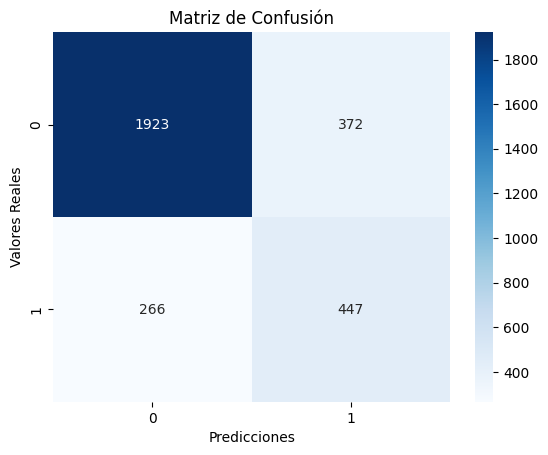

In [169]:
dataClass = pd.concat([dataClass,pd.DataFrame([{'Modelo': "Red Neuronal", 'Accuracy': accuracy,
                                  'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC-AUC': roc_auc}])], ignore_index=True)
confusionMatrix(y_test,y_pred)


In [170]:

# Especifica las métricas que deseas graficar
columnas_metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

# Reformula el DataFrame para tener una fila por métrica
data_melted = dataClass.melt(id_vars=['Modelo'], value_vars=columnas_metricas, var_name='Métrica', value_name='Valor de la Métrica')

# Redondea los valores a 3 decimales
data_melted['Valor de la Métrica'] = data_melted['Valor de la Métrica'].round(3)

# Crear un gráfico de barras agrupadas para cada modelo
fig = px.bar(data_melted, x='Modelo', y='Valor de la Métrica', color='Métrica',
             title='Gráfico de Barras para Cada Métrica por Modelo',
             labels={'Modelo': 'Modelo', 'Valor de la Métrica': 'Valor de la Métrica', 'Métrica': 'Métrica'},
             barmode='group', text='Valor de la Métrica', height=500)

fig.show()

## Explicabilidad con SHAP

In [171]:
model=best_model_class


In [172]:
explainer = shap.Explainer(model, X_train_preprocessed, feature_names=feature_names)

PermutationExplainer explainer: 3009it [08:16,  6.02it/s]


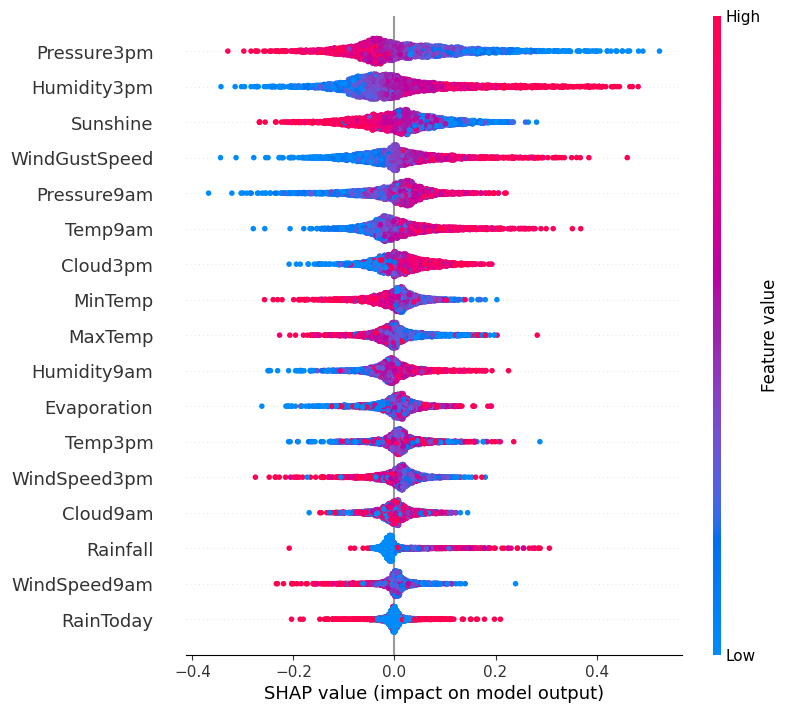

In [173]:
explanation = explainer(X_test_preprocessed)
shap.plots.beeswarm(explanation, max_display=None)

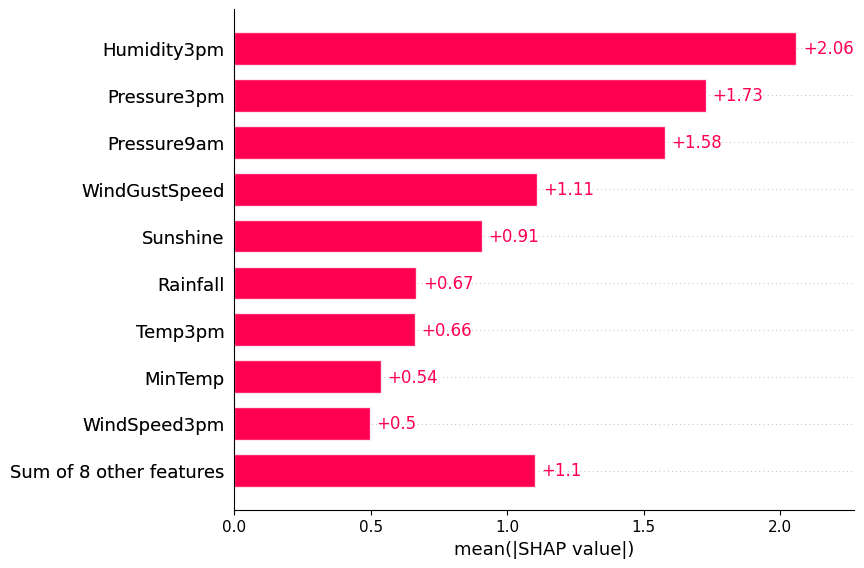

In [222]:
shap.plots.bar(explanation)

## Exportación de Pipe

In [178]:
best_model_class2=modelos['Desbalanceado']

In [179]:
!pip install imbalanced-learn


In [180]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Crear el pipeline para imputación y estandarización
regresion_logistica_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación por la media
    ('scaler', StandardScaler()),
    #('oversampler', SMOTE()),
    ('classifier', best_model_class),
])

regresion_logistica_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred = (regresion_logistica_pipeline.predict(X_test_preprocessed) > 0.5).astype(int)

# # Ajustar y transformar el conjunto de entrenamiento
# X_train_preprocessed  = preprocessing_pipeline.fit_transform(X_train)

# # Transformar el conjunto de prueba utilizando los parámetros aprendidos del conjunto de entrenamiento
#X_test_preprocessed  = preprocessing_pipeline.transform(X_test)

94/94 [==============================] - 1s 7ms/step


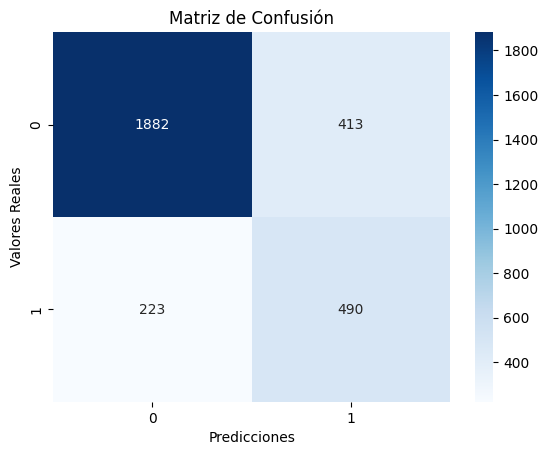

In [181]:
confusionMatrix(y_test,y_pred)


# Modelos de regresion para Rainfalltomorrow

## Regresion Lineal Multiple

In [193]:

# Separar features (X) y target (y)
X2 = df_codificado_para_pipe.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y2 = df_codificado_para_pipe['RainfallTomorrow']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Crear el pipeline para imputación y estandarización
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación por la media
    ('scaler', StandardScaler()),  # Estandarización con la media y desviación estándar del conjunto de entrenamiento
])

In [194]:

# Calcular la media de la variable objetivo en el conjunto de entrenamiento
mean_rainfall = y_train.mean()

# Crear un array con la media repetida para el conjunto de prueba
naive_predictions = pd.Series([mean_rainfall] * len(y_test), index=y_test.index)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, naive_predictions)
r2 = r2_score(y_test, naive_predictions)
rmse= mean_squared_error(y_test, naive_predictions, squared=False)
mae = mean_absolute_error(y_test, naive_predictions)
mape = (mae / np.mean(y_test)) * 100

# Imprimir métricas para 'RainfallTomorrow'
print("\nMétricas para RainfallTomorrow:")
print("R2 Score:", r2.round(4))
print("Mean Squared Error:", mse.round(4))
print("Root Mean Squared Error:", rmse.round(4))
print("Mean Absolute Error:",mae.round(4))
print("MAPE:",mape.round(4))


Métricas para RainfallTomorrow:
R2 Score: -0.3928
Mean Squared Error: 0.2519
Root Mean Squared Error: 0.5019
Mean Absolute Error: 0.5019
MAPE: 211.7302


In [195]:
# Ajustar y transformar el conjunto de entrenamiento
preprocessing_pipeline.fit(X_train_reg,y_train_reg)
X_train_preprocessedR  = preprocessing_pipeline.fit_transform(X_train_reg)

# Transformar el conjunto de prueba utilizando los parámetros aprendidos del conjunto de entrenamiento
X_test_preprocessedR  = preprocessing_pipeline.transform(X_test_reg)

In [196]:
dataReg = pd.DataFrame(columns=['Modelo', 'R2', 'R2 Ajustado', 'R2 Train', 'MSE', 'RMSE','MAE'])


In [199]:
def residuos(y_pred,y_test_reg):
  y_test_reg = np.squeeze(y_test_reg)
  y_pred = np.squeeze(y_pred)
  residuos = y_test_reg -y_pred

  # Crea un gráfico de dispersión de residuos utilizando Seaborn
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=y_test_reg, y=y_pred)
  plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')  # Línea diagonal de referencia
  plt.title('Gráfico de comparacion Y_Test Y_Pred')
  plt.xlabel('Valores Test')
  plt.ylabel('Valores Calculados')
  plt.show()

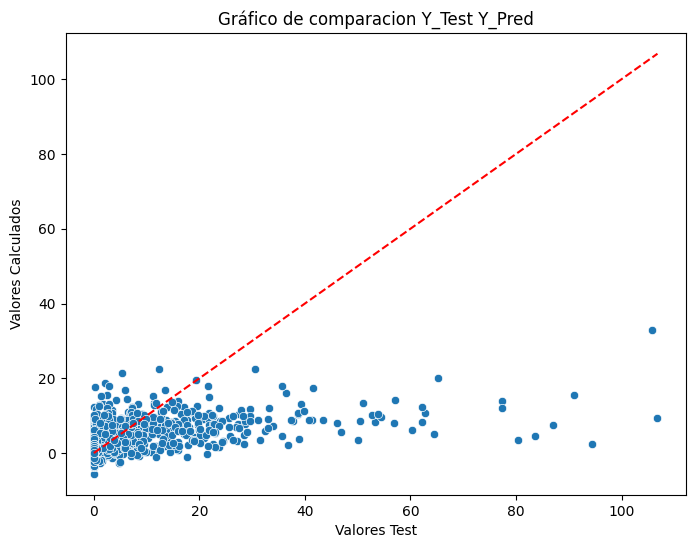

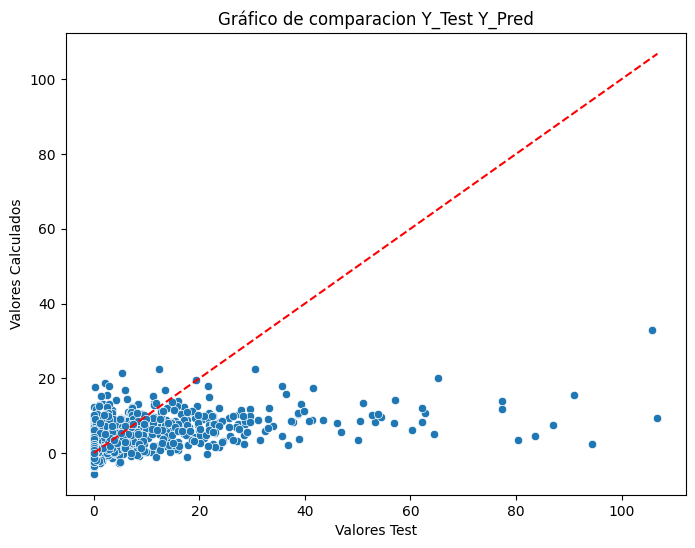

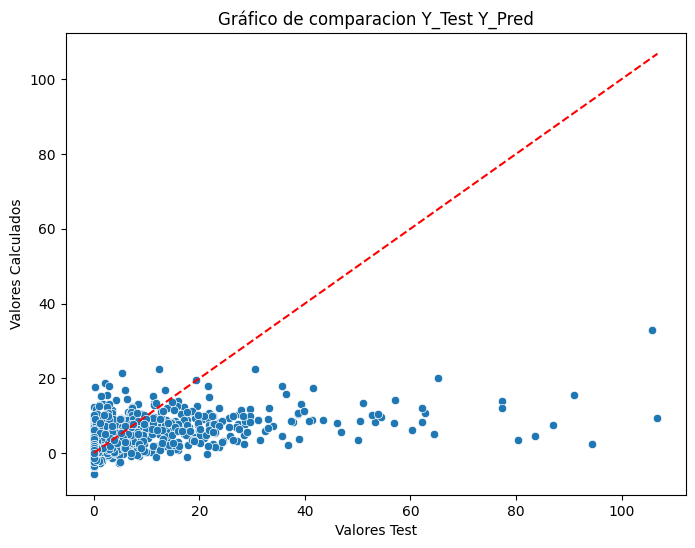

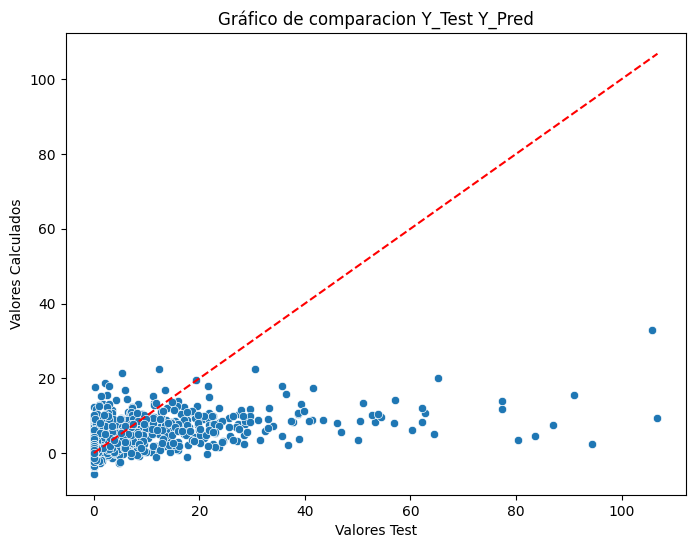


Results for Linear Regression:
{'best_params': 'Regresion lineal', 'mae': 3.2601, 'mse': 52.9534, 'rmse': 7.2769, 'mape': inf, 'r2': 0.2276, 'adj_r2': 0.2232}

Results for Ridge Regression:
{'best_params': {'alpha': 10}, 'mae': 3.2591, 'mse': 52.9653, 'rmse': 7.2777, 'mape': inf, 'r2': 0.2274, 'adj_r2': 0.223}

Results for Lasso Regression:
{'best_params': {'alpha': 0.001}, 'mae': 3.2591, 'mse': 52.9628, 'rmse': 7.2776, 'mape': inf, 'r2': 0.2275, 'adj_r2': 0.2231}

Results for ElasticNet Regression:
{'best_params': {'alpha': 0.001}, 'mae': 3.259, 'mse': 52.9652, 'rmse': 7.2777, 'mape': inf, 'r2': 0.2274, 'adj_r2': 0.223}


In [200]:


# Definir las métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - X_train_preprocessedR.shape[1] - 1))
    return mae, mse, rmse, mape, r2, adj_r2


# Crear los modelos
linear_regression = LinearRegression()
ridge_regression = Ridge()
lasso_regression = Lasso()
elasticnet_regression = ElasticNet()

# Definir los parámetros para la búsqueda de hiperparámetros
param_grid_ridge_lasso_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Realizar la búsqueda de hiperparámetros con validación cruzada para Ridge, Lasso y ElasticNet
models = [
    ('Linear Regression', linear_regression,None),
    ('Ridge Regression', Ridge(), param_grid_ridge_lasso_elasticnet),
    ('Lasso Regression', Lasso(), param_grid_ridge_lasso_elasticnet),
    ('ElasticNet Regression', ElasticNet(), param_grid_ridge_lasso_elasticnet)
]

results = {}
modelos= {}
for name, model, params in models:
    if name == 'Linear Regression':
        # No es necesario ajustar hiperparámetros para Linear Regression
        best_model = model.fit(X_train_preprocessedR, y_train_reg)
    else:
        grid_search = GridSearchCV(model, params, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')
        grid_search.fit(X_train_preprocessedR, y_train_reg)
        best_model = grid_search.best_estimator_

    # Hacer predicciones en el conjunto de prueba
    y_pred = best_model.predict(X_test_preprocessedR)

    # Calcular métricas
    mae, mse, rmse, mape, r2, adj_r2 = calculate_metrics(y_test_reg, y_pred)

    # Almacenar resultados en el diccionario
    results[name] = {
        'best_params': grid_search.best_params_ if name != 'Linear Regression' else "Regresion lineal",
        'mae': mae.round(4),
        'mse': mse.round(4),
        'rmse': rmse.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4),
        'adj_r2': adj_r2.round(4)
    }
    nuevas_filas = pd.DataFrame({
    'Modelo': [name],
    'R2': [r2],
    'R2 Ajustado':[adj_r2] ,
    'R2 Train': [r2_score(y_train_reg, best_model.predict(X_train_preprocessedR))],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],

      })
    modelos[name]=model
    dataReg = pd.concat([dataReg, nuevas_filas], ignore_index=True)
    residuos(y_pred,y_test_reg)

# Imprimir resultados
for name, metrics in results.items():
    print(f"\nResults for {name}:\n{metrics}")

En las graficas de residuos se observa una poca aleatoriedad en la distribucion de los datos lo que sugiere que el modelo de regresion lineal no es suficiente para calcular la variable en estudio

In [202]:

# Crear un modelo de regresión lineal con SGD
model_sgd = SGDRegressor()

# Entrenar el modelo en el conjunto de entrenamiento
model_sgd.fit(X_train_preprocessedR, y_train_reg)

# Hacer predicciones en el conjunto de prueba
y_pred_sgd = model_sgd.predict(X_test_preprocessedR)

# Evaluar el modelo
r2_sgd_rainfall_tomorrow = r2_score(y_test_reg, y_pred_sgd)
mse_sgd_rainfall_tomorrow = mean_squared_error(y_test_reg, y_pred_sgd)
rmse_sgd_rainfall_tomorrow = mean_squared_error(y_test_reg, y_pred_sgd, squared=False)
mae_sgd_rainfall_tomorrow = mean_absolute_error(y_test_reg, y_pred_sgd)

r2_sgd_rainfall_tomorrow_train = r2_score(y_train_reg,model_sgd.predict(X_train_preprocessedR))

# Imprimir métricas para 'RainfallTomorrow'
print("\nMétricas para RainfallTomorrow:")
print("R2 Score:", r2_sgd_rainfall_tomorrow.round(4))
print("Mean Squared Error:", mse_sgd_rainfall_tomorrow.round(4))
print("Root Mean Squared Error:", rmse_sgd_rainfall_tomorrow.round(4))
print("Mean Absolute Error:", mae_sgd_rainfall_tomorrow.round(4))
print('R² adj: ',(1-((1-model_sgd.score(X_test_preprocessedR, y_test_reg))*((len(X_test)-1)))/(len(X_test)-(len(X_test.columns)-1))).round(4))
print("R2 Score Train:", r2_sgd_rainfall_tomorrow_train.round(4))


Métricas para RainfallTomorrow:
R2 Score: 0.23
Mean Squared Error: 52.7882
Root Mean Squared Error: 7.2656
Mean Absolute Error: 3.4184
R² adj:  0.2261
R2 Score Train: 0.2229


In [203]:
nuevas_filas = pd.DataFrame({
    'Modelo': "Gradiente Descendiente",
    'R2': [r2_sgd_rainfall_tomorrow],
    'R2 Ajustado':[adj_r2] ,
    'R2 Train': [r2_sgd_rainfall_tomorrow_train],
    'MSE': [mse_sgd_rainfall_tomorrow],
    'RMSE': [rmse_sgd_rainfall_tomorrow],
    'MAE': [mae_sgd_rainfall_tomorrow],

      })
dataReg = pd.concat([dataReg, nuevas_filas], ignore_index=True)

In [204]:
metricas = ['R2', 'R2 Ajustado', 'MSE', 'RMSE', 'MAE', 'R2 Train']

fig = go.Figure()

for metrica in metricas:
    fig.add_trace(go.Bar(x=dataReg['Modelo'], y=dataReg[metrica], name=metrica))


fig.update_layout(barmode='group', title='Comparación de Métricas entre Modelos')
fig.show()

# **Explicabilidad SHAP**

In [205]:
model=modelos['Linear Regression']

In [206]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model, X_train_preprocessedR, feature_names=feature_names)

In [207]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_preprocessedR)

In [208]:
shap_values.shape

(3008, 17)

In [209]:
explainer.expected_value

1.8711438111405996

## Interpretabilidad **local**

In [210]:
shap_values[0]

array([-0.93363329,  0.8585346 , -0.43531775,  0.27211893,  1.86834916,
        2.71865915, -0.28985963, -0.26513228,  0.35076265, -5.48375804,
       -3.77283834,  4.42459775, -0.26185514,  0.04163079,  0.12819019,
        2.05780279, -0.04773218])

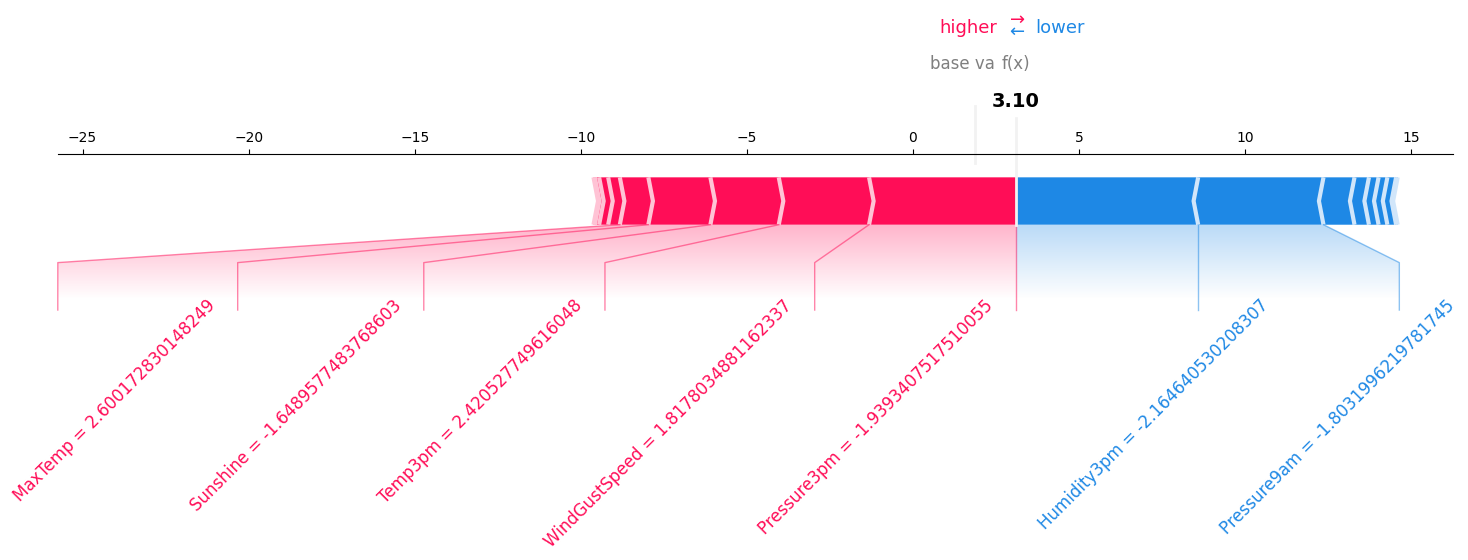

In [211]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], X_test_preprocessedR[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
                text_rotation=45)

In [212]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)


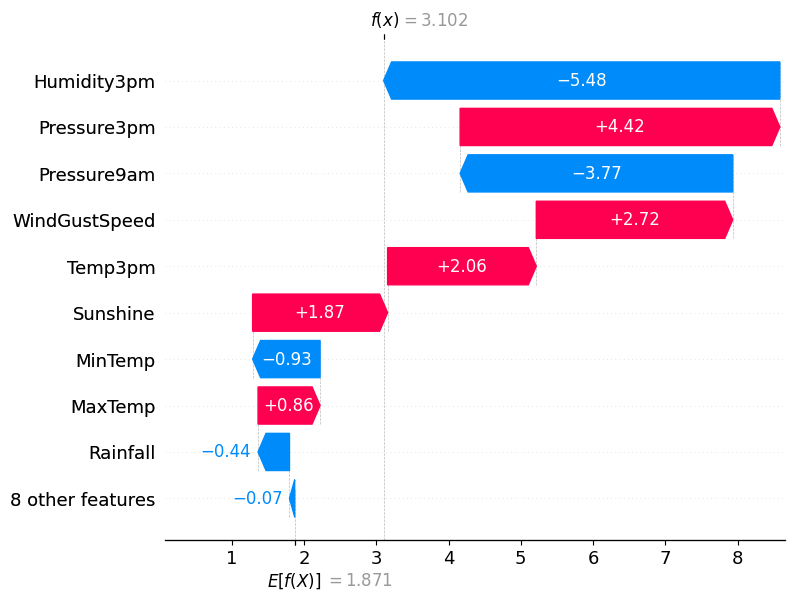

In [213]:
shap.plots.waterfall(explanation)

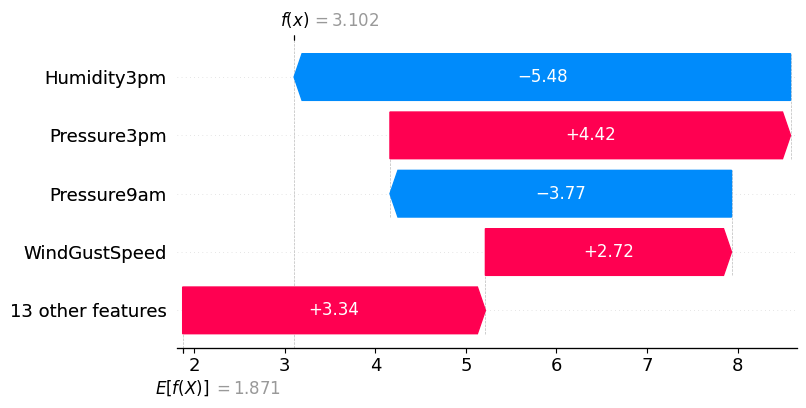

In [214]:
shap.plots.waterfall(explanation, max_display=5)

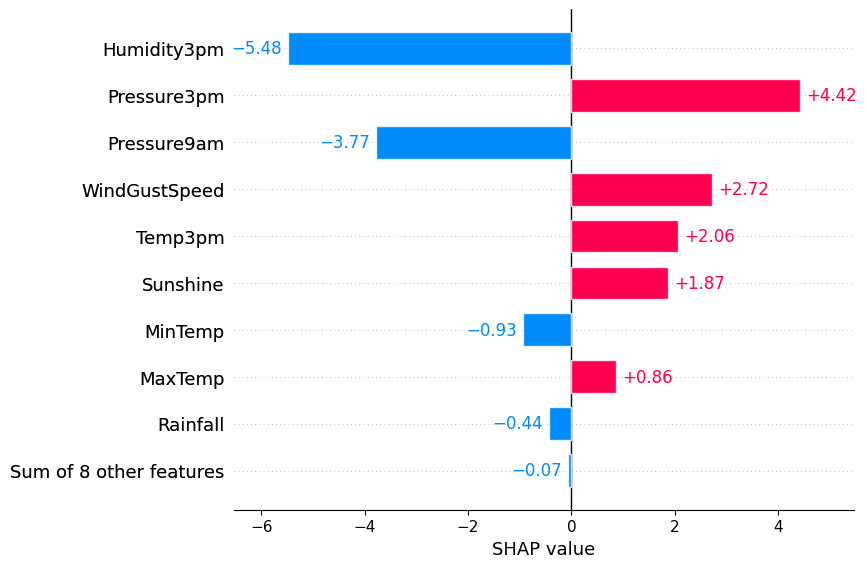

In [215]:
shap.plots.bar(explanation)

En este caso particula observamos que humidity3pm y presion9am son las variables que mas restan por un gran margen, mientras que presion3pm otras tienen valores positivos mas parejos.
Tambien se observa que 8 features sumadas alcanzan tan solo un -0.07

## Interpretabilidad **global**

In [216]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_preprocessedR)

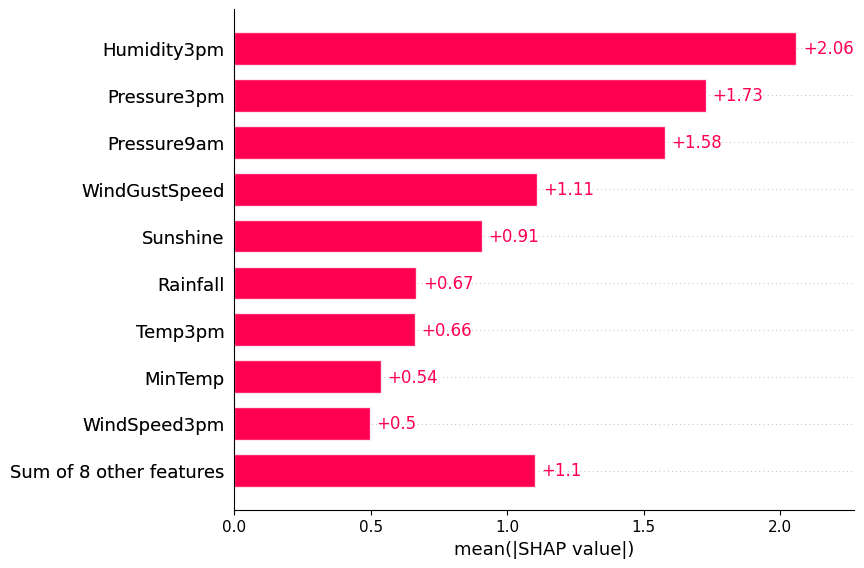

In [217]:
shap.plots.bar(explanation)

Valor absoluto media de esa feature para todas las muestras

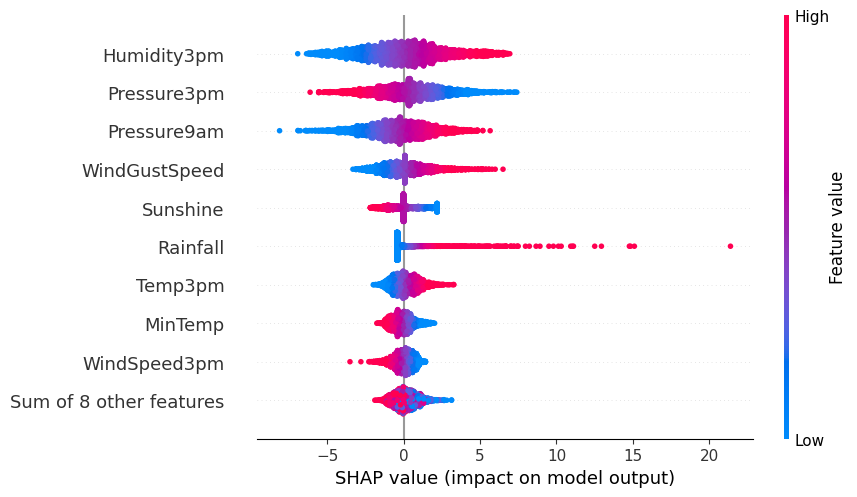

In [218]:
shap.plots.beeswarm(explanation)


 Humidity3pm tiene el mayor impacto positivo en la predicción, lo que significa que un aumento en Humidity3pm probablemente aumentará la predicción del modelo.

Pressure9am tiene el mayor impacto negativo en la predicción, lo que significa que un aumento en Pressure9am probablemente disminuirá la predicción del modelo.

# Modelo de Redes Neuronales para Regresion lineal

In [219]:



# Separar un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_preprocessedR, y_train_reg, test_size=0.2, random_state=42)

# Función objetivo para la optimización de Optuna
def objective(trial):
    # Definir el modelo de Keras
    model = Sequential()

    # Número óptimo de capas ocultas (entre 1 y 3)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)

    # Tamaño de cada capa oculta (entre 8 y 128 nodos)
    hidden_layer_sizes = [trial.suggest_int(f'n_units_l{i}', 8, 64) for i in range(num_hidden_layers)]

    # Agregar capas ocultas al modelo
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_layer_sizes[i], activation='relu'))
        model.add(Dropout(0.5))  # Puedes ajustar la tasa de dropout según sea necesario

    # Capa de salida
    model.add(Dense(1, activation='linear'))  # Salida lineal para regresión

    # Optimizador y tasa de aprendizaje
    optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True))

    # Compilar el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])

    # Entrenamiento del modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=trial.suggest_int('epochs', 10, 500),
        batch_size=trial.suggest_int('batch_size', 256, 2048),
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluación del modelo en el conjunto de validación
    y_pred = model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_pred)

    return val_loss

# Crear un estudio de Optuna y realizar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

# Imprimir los resultados
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')  # Imprimir la pérdida mínima alcanzada
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Entrenar el modelo con la mejor configuración encontrada
# best_modelReg = Sequential()
# for i in range(trial.params['num_hidden_layers']):
#     best_modelReg.add(Dense(trial.params[f'n_units_l{i}'], activation='relu'))

# best_modelReg.add(Dense(1, activation='linear'))
# best_modelReg.compile(optimizer=Adam(learning_rate=trial.params['learning_rate']), loss='mean_squared_error',metrics=['mean_squared_error'])
# best_modelReg.fit(X_train, y_train, epochs=trial.params['epochs'], batch_size=trial.params['batch_size'])


[I 2023-12-07 21:06:44,698] A new study created in memory with name: no-name-fffd80fb-0ba8-40c8-9cb9-a12c2415721a


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:06:52,259] Trial 0 finished with value: 44.98659568277312 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 30, 'n_units_l1': 32, 'n_units_l2': 58, 'learning_rate': 0.0006862262378061834, 'epochs': 127, 'batch_size': 584}. Best is trial 0 with value: 44.98659568277312.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:06:56,176] Trial 1 finished with value: 42.288083209044444 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 9, 'n_units_l1': 52, 'learning_rate': 0.07597971776615084, 'epochs': 345, 'batch_size': 1948}. Best is trial 1 with value: 42.288083209044444.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:07:12,390] Trial 2 finished with value: 52.12944984719988 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 35, 'learning_rate': 5.775190421777075e-05, 'epochs': 147, 'batch_size': 804}. Best is trial 1 with value: 42.288083209044444.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:07:34,244] Trial 3 finished with value: 39.63792453801037 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 54, 'n_units_l1': 47, 'learning_rate': 0.0007663431463870999, 'epochs': 498, 'batch_size': 1517}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:08:16,564] Trial 4 finished with value: 42.84277163908707 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 49, 'n_units_l1': 51, 'learning_rate': 9.771735677917298e-05, 'epochs': 241, 'batch_size': 618}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:09:40,447] Trial 5 finished with value: 60.96223749755093 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 26, 'n_units_l1': 13, 'n_units_l2': 62, 'learning_rate': 1.0802101121897181e-05, 'epochs': 495, 'batch_size': 1875}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 3ms/step


[I 2023-12-07 21:10:03,857] Trial 6 finished with value: 44.43653137472702 and parameters: {'num_hidden_layers': 3, 'n_units_l0': 28, 'n_units_l1': 39, 'n_units_l2': 24, 'learning_rate': 0.00045129609145573406, 'epochs': 124, 'batch_size': 1458}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 3ms/step


[I 2023-12-07 21:10:17,804] Trial 7 finished with value: 42.91182928414951 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 28, 'n_units_l1': 62, 'learning_rate': 0.00044157019521757086, 'epochs': 206, 'batch_size': 1332}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:11:00,112] Trial 8 finished with value: 47.57959797429601 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 21, 'learning_rate': 0.00011722867381942685, 'epochs': 415, 'batch_size': 1850}. Best is trial 3 with value: 39.63792453801037.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:11:06,587] Trial 9 finished with value: 39.56627085914036 and parameters: {'num_hidden_layers': 2, 'n_units_l0': 22, 'n_units_l1': 9, 'learning_rate': 0.009719000597546027, 'epochs': 227, 'batch_size': 2016}. Best is trial 9 with value: 39.56627085914036.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:11:12,989] Trial 10 finished with value: 38.777788606015434 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.013678239057336247, 'epochs': 59, 'batch_size': 259}. Best is trial 10 with value: 38.777788606015434.


76/76 [==============================] - 0s 1ms/step


[I 2023-12-07 21:11:16,701] Trial 11 finished with value: 44.91117539077471 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 8, 'learning_rate': 0.011795510506372417, 'epochs': 18, 'batch_size': 971}. Best is trial 10 with value: 38.777788606015434.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:11:20,875] Trial 12 finished with value: 40.648818023080445 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.006472662716483242, 'epochs': 25, 'batch_size': 375}. Best is trial 10 with value: 38.777788606015434.


76/76 [==============================] - 0s 2ms/step


[I 2023-12-07 21:11:32,394] Trial 13 finished with value: 38.32109054805583 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 16, 'learning_rate': 0.005505907025441752, 'epochs': 327, 'batch_size': 301}. Best is trial 13 with value: 38.32109054805583.


76/76 [==============================] - 0s 1ms/step


[I 2023-12-07 21:11:45,256] Trial 14 finished with value: 37.91591101453519 and parameters: {'num_hidden_layers': 1, 'n_units_l0': 43, 'learning_rate': 0.003891674474036775, 'epochs': 342, 'batch_size': 273}. Best is trial 14 with value: 37.91591101453519.


Best trial:
Value: 37.91591101453519
Params: 
    num_hidden_layers: 1
    n_units_l0: 43
    learning_rate: 0.003891674474036775
    epochs: 342
    batch_size: 273


In [220]:
optuna.visualization.plot_optimization_history(study, target_name="MSE RainfallTomorrow")

In [221]:
optuna.visualization.plot_param_importances(study, target_name="MSE RainfallTomorrow")

Graficas de la evolucion del ensayo de optuna y el impacto de los hiperparametros testeados en los mismos.

In [223]:
best_modelReg = Sequential()
for i in range(trial.params['num_hidden_layers']):
    best_modelReg.add(Dense(trial.params[f'n_units_l{i}'], activation='relu'))
best_modelReg.add(Dense(1, activation='linear'))
best_modelReg.compile(optimizer=Adam(learning_rate=trial.params['learning_rate']), loss='mean_squared_error',metrics=['mean_squared_error'])
best_modelReg.fit(X_train_preprocessedR, y_train_reg, epochs=trial.params['epochs'], batch_size=trial.params['batch_size'])


Epoch 1/342
45/45 [==============================] - 1s 3ms/step - loss: 43.1807 - mean_squared_error: 43.1807
Epoch 2/342
45/45 [==============================] - 0s 3ms/step - loss: 38.1833 - mean_squared_error: 38.1833
Epoch 3/342
45/45 [==============================] - 0s 3ms/step - loss: 36.7068 - mean_squared_error: 36.7068
Epoch 4/342
45/45 [==============================] - 0s 3ms/step - loss: 36.0086 - mean_squared_error: 36.0086
Epoch 5/342
45/45 [==============================] - 0s 3ms/step - loss: 35.7463 - mean_squared_error: 35.7463
Epoch 6/342
45/45 [==============================] - 0s 4ms/step - loss: 35.2848 - mean_squared_error: 35.2848
Epoch 7/342
45/45 [==============================] - 0s 3ms/step - loss: 34.9979 - mean_squared_error: 34.9979
Epoch 8/342
45/45 [==============================] - 0s 4ms/step - loss: 34.7105 - mean_squared_error: 34.7105
Epoch 9/342
45/45 [==============================] - 0s 3ms/step - loss: 34.4311 - mean_squared_error: 34.4311
E

In [224]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Hacer predicciones en el conjunto de prueba
y_pred = best_modelReg.predict(X_test_preprocessedR)

# Calcular métricas
mae = mean_absolute_error(y_test_reg, y_pred)
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred)
r2_train= r2_score(y_train_reg, best_modelReg.predict(X_train_preprocessedR))
# Calcular R^2 ajustado
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calcular MAPE
#mape = np.mean(np.abs((y_test_reg - y_pred) / y_test_reg)) * 100

# Imprimir resultados
print(f'MAE: {mae.round(4)}')
print(f'MSE: {mse.round(4)}')
print(f'RMSE: {rmse.round(4)}')
print(f'R^2: {r2.round(4)}')
print(f'R^2 ajustado: {adj_r2.round(4)}')
print(f'R2 train: {r2_train.round(4)}')
#print(f'MAPE: {mape}')


376/376 [==============================] - 1s 1ms/step
MAE: 3.1418
MSE: 45.4904
RMSE: 6.7447
R^2: 0.3365
R^2 ajustado: 0.3327
R2 train: 0.4503


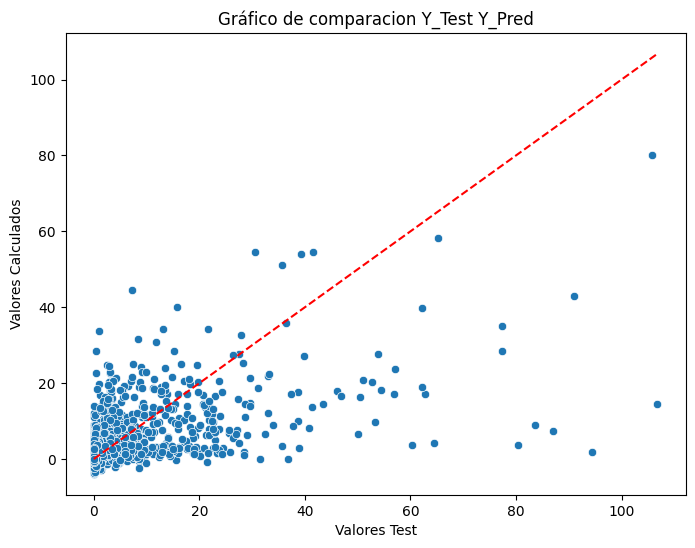

In [225]:
y_test_reg = np.squeeze(y_test_reg)
y_pred = np.squeeze(y_pred)
residuos = y_test_reg -y_pred

# Crea un gráfico de dispersión de residuos utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=y_pred)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')  # Línea diagonal de referencia
plt.title('Gráfico de comparacion Y_Test Y_Pred')
plt.xlabel('Valores Test')
plt.ylabel('Valores Calculados')
plt.show()

## Explicabilidad

In [226]:
model=best_modelReg


In [227]:
explainer = shap.Explainer(model, X_train_preprocessed, feature_names=feature_names)

PermutationExplainer explainer: 3009it [04:21, 11.05it/s]


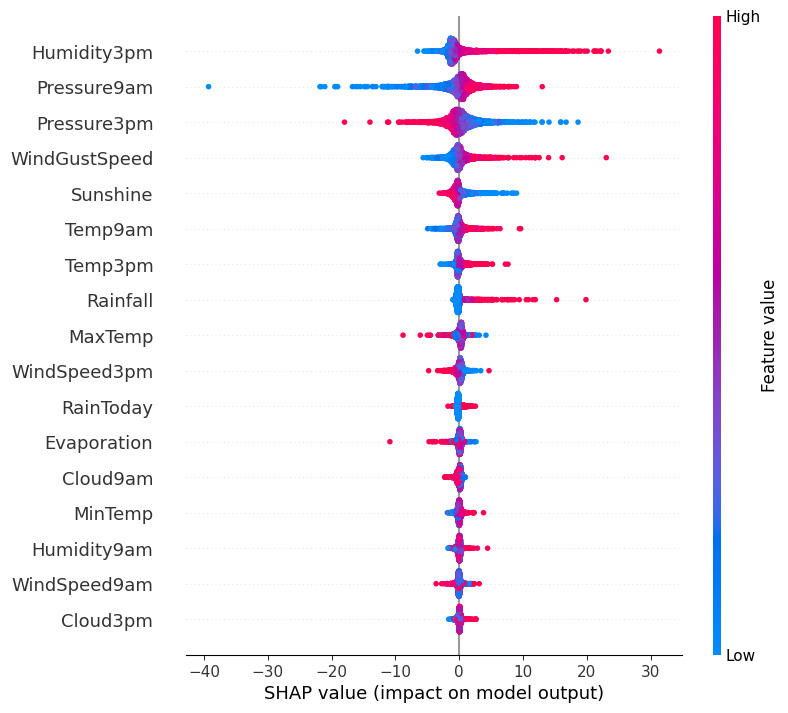

In [228]:
explanation = explainer(X_test_preprocessed)
shap.plots.beeswarm(explanation, max_display=None)

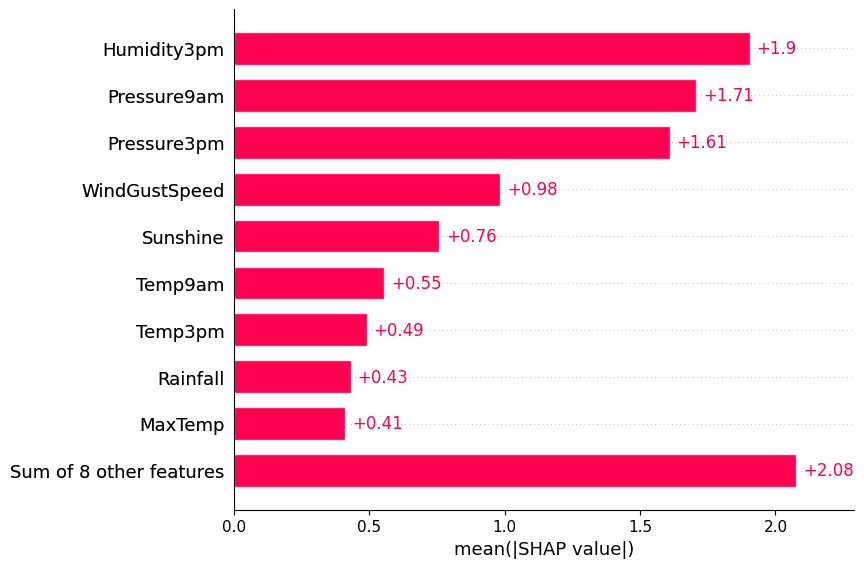

In [229]:
shap.plots.bar(explanation)

In [230]:
# Inicializa SHAP
#shap.initjs()

# Crea un conjunto de datos de fondo
background = X_train_preprocessedR[np.random.choice(X_train_preprocessedR.shape[0], 100, replace=False)]

# Crea un Explainer
explainer = shap.DeepExplainer(model, background)

# Calcula los valores SHAP
shap_values = explainer.shap_values(X_test_preprocessedR)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:100: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



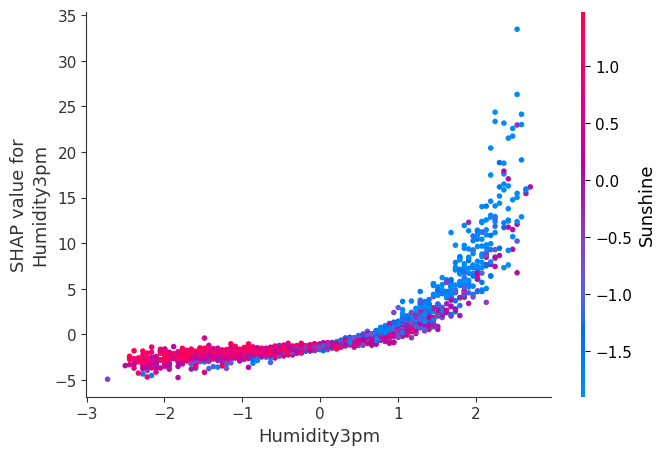

In [232]:
shap.dependence_plot("Humidity3pm", shap_values[0], X_test_preprocessedR,feature_names=feature_names)


In [240]:
def f(X):
    return model.predict([X_train_preprocessedR[:, i] for i in range(X_train_preprocessedR.shape[1])]).flatten()

## Exportación de Pipe

In [234]:

# Separar features (X) y target (y)
X = df_codificado_para_pipe.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y = df_codificado_para_pipe['RainfallTomorrow']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para imputación y estandarización
regresion_lineal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación por la media
    ('scaler', StandardScaler()),
    ('regressor', best_modelReg), # Estandarización con la media y desviación estándar del conjunto de entrenamiento
])



# # Ajustar y transformar el conjunto de entrenamiento
# X_train_preprocessed  = preprocessing_pipeline.fit_transform(X_train)

# # Transformar el conjunto de prueba utilizando los parámetros aprendidos del conjunto de entrenamiento
#X_test_preprocessed  = preprocessing_pipeline.transform(X_test)

In [235]:
regresion_lineal_pipeline.fit(X_train, y_train)

376/376 [==============================] - 1s 2ms/step - loss: 29.8511 - mean_squared_error: 29.8511


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('regressor',
                 <keras.src.engine.sequential.Sequential object at 0x7a92fb5a1c60>)])

Exportacion de pipes para MLOPS

In [236]:

joblib.dump(regresion_lineal_pipeline, 'regresion_lineal_pipeline.pkl')
joblib.dump(regresion_logistica_pipeline, 'regresion_logistica_pipeline.pkl')


['regresion_logistica_pipeline.pkl']

# Conclusiones:
A lo largo de este trabajo iterativo e incremental fuimos aplicando los contenidos dados en cada unidad culminando en una pequeña aplicacion de produccion donde se predecin nuestras dos variables objetivo.
Se realizaron las tareas de un Analisis Exploratorio, tipo de variables, datos faltantes, graficas sobre los datos, y visualziacion de la proporcion de las categorias a clasificar junto a una matriz de correlacion.
A partir de aque se tomaron las primeras decisiones sobre las features para los modelos.
- Los datos nuemricos faltantes se imputaron por la media
- las filas donde faltaban valores de alguna de las target se dropearon del dataset
- Se descartaron las variables catergoricas, quedando solo RainTomorrow como target y RainToday como feature. Ambas fueron codificadas en forma binaria

Luego se creo una estructura de pipe para el procesamiento consitente en la imputacion mencionada y el escalador estandar de los datos.

A partir de aqui se construyeron los modelos:
- Modelos base en ambos casos para obtener las primeras metricas
- Clasificacion: regresion logistica sobre el dataset original, y con 3 tipos de balanceo, under, over y SMOTE.
Los 3 modelos balanceados tuvieron performace muy similar mejorando nuestra metirica objetivo que es el Recall o TPR.
- Modelo de RN en tensoflow con optimizacion de optuna. Se aprendia rapidamente los datos de entrenamiento y aunque mejoraba las metricas en la seleccionada en particular tuvo un desempeño menor que los modelos de sklearn.
- Regresion: regresion lineal multiple, con Rigde, Lasso, ElasticNet y Descenso gradiente.
Todoas presentaron malos resultados muy similares entre ellos lo que indica deficiencias del tipo de modelo para con los datos.
- Modelo de RN: aprendio extremadamente rapido el conjunto de entrenamiento alcanzando r2 de .96 en 20 ensayos de optuna. Se limitaron la cantidad de ensayos, neuronas y capas, para mermar el overfitting.
Tuvo un desempeño mejor que los modelos de sklearn por lo que fue elegido junto a la regresion lineal sobre SMOTE para exportarse como pipelines al MLOPS

Tambien se aplico explicabilidad global y local, resultando útil para obtner graficas explicativas de como se llegaban a los resultados en cada modelo evaluado. Unas pocas features concentraban el mayor peso en el resultado, mientras que las restantas aportaban relativamente poco.

Por ultimo se uso streamlit para generar un frontend donde imputar nuevos datos y obtener el resultado empleando las tuberias creadas en este notebook.

Enlace al deploy via Hugging Face:
[link](https://huggingface.co/spaces/rv3r/AA-PrecitipitationsAustraliaPredictions)